## Imports + Setup

In [43]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import sys

sys.path.append("../")

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cortex
import seaborn as sns

# set random seed
seed = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Inspect Natural Scenes Dataset (NSD)

### Load data

In [44]:
sys.path.append("../neurometry/rep_metrics/")
from neurometry.rep_metrics.load_nsd import load_nsd
from neurometry.rep_metrics.load_nsd import get_neural_data
from neurometry.rep_metrics.anatomy import get_subjects_rois, get_roi_list_intersection

In [45]:
target_regions = ["EVC", "OTC"]

subjects = ["subj01", "subj02", "subj05", "subj07"]

response_data, voxel_metadata, stimulus_data, functional_rois = load_nsd(target_regions)

Now loading the shared1000 image set and the EVC-only voxel set...


Now loading the shared1000 image set and the OTC-only voxel set...


In [4]:
# Anatomical data
anatomical_rois = get_subjects_rois(subjects)

# Consider only common ROIs (TODO: fix pycortex roi hand-drawn definitions)
rois = {}
for subject in subjects:
    rois[subject] = get_roi_list_intersection(functional_rois, anatomical_rois[subject])

rois["subj02"].remove(
    "OPA"
)  # (sometimes) gives nans in many geodesic computations, not sure why

neural_data = get_neural_data(subjects, rois, voxel_metadata, response_data)

/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (floc-places) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (floc-faces) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (floc-bodies) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (prf-visualrois) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%s

Subject 1 has 662 voxels in region VWFA-1
Subject 1 has 269 voxels in region OFA
Subject 1 has 333 voxels in region FBA-1
Subject 1 has 2525 voxels in region EBA
Subject 1 has 418 voxels in region FFA-1
Subject 1 has 211 voxels in region FFA-2
Subject 1 has 1173 voxels in region OPA
Subject 1 has 359 voxels in region OWFA
Subject 1 has 734 voxels in region PPA
Subject 1 has 313 voxels in region FBA-2
Subject 1 has 355 voxels in region VWFA-2
Subject 2 has 287 voxels in region VWFA-1
Subject 2 has 288 voxels in region OFA
Subject 2 has 2562 voxels in region EBA
Subject 2 has 274 voxels in region FFA-1
Subject 2 has 343 voxels in region FFA-2
Subject 2 has 352 voxels in region OWFA
Subject 2 has 749 voxels in region PPA
Subject 2 has 783 voxels in region FBA-2
Subject 2 has 165 voxels in region VWFA-2
Subject 5 has 422 voxels in region VWFA-1
Subject 5 has 666 voxels in region OFA
Subject 5 has 404 voxels in region FBA-1
Subject 5 has 3354 voxels in region EBA
Subject 5 has 382 voxels in

### Stimulus image information

Shared1000 (1000 images seen by all 8 subjects)

In [5]:
stimulus_data.head()

image_id image_name                                   coco_supercategs  \
0       584    584.jpg  ['kitchen', 'food', 'food', 'food', 'food', 'f...   
1       605    605.jpg     ['furniture', 'kitchen', 'kitchen', 'kitchen']   
2       625    625.jpg           ['person', 'person', 'person', 'sports']   
3       650    650.jpg                              ['animal', 'vehicle']   
4      1308   1308.jpg                               ['person', 'sports']   

                                         coco_categs  \
0  ['spoon', 'broccoli', 'broccoli', 'carrot', 'c...   
1            ['dining table', 'cup', 'spoon', 'cup']   
2          ['person', 'person', 'person', 'frisbee']   
3                                     ['cat', 'car']   
4                            ['person', 'surfboard']   

                                          coco_areas  \
0  [8202.7375, 2029.63, 9312.366699999997, 4341.8...   
1  [292230.67579999997, 27883.840000000007, 3167....   
2  [9374.5, 12506.5, 8855.840100000001, 367.68849...   
3             [58308.82059999999, 63482.26930000002]   
4            [6685.614199999999, 1742.0500000000015]   

                                       coco_captions  \
0  ['a plate of yummy food of some kind', 'Food o...   
1  ['A cup of coffee on a plate with a spoon.', '...   
2  ['Three young women are trying to catch a fris...   
3  ['a cat is sitting on top of a vehicle', 'A ca...   
4  ['A man in swim shorts is riding a surf board....   

                                          image_path  
0  /home/facosta/neurometry/neurometry/rep_metric...  
1  /home/facosta/neurometry/neurometry/rep_metric...  
2  /home/facosta/neurometry/neurometry/rep_metric...  
3  /home/facosta/neurometry/neurometry/rep_metric...  
4  /home/facosta/neurometry/neurometry/rep_metric...

Entire stimulus set (73000 images)

In [6]:
file_path = "/scratch/facosta/NSD/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5"

import h5py
import pickle

with h5py.File(file_path, "r") as f:
    img_brick_dataset = f["imgBrick"]
    print(f"Shape of the dataset: {img_brick_dataset.shape}")
    print(f"Data type of the dataset: {img_brick_dataset.dtype}")

    data = img_brick_dataset[:]

images_info_file_path = "/home/facosta/superposition/rep_drift/nsd_stim_info_merged.pkl"

with open(images_info_file_path, "rb") as f:
    images_info = pickle.load(f, encoding="latin1")

Shape of the dataset: (73000, 425, 425, 3)
Data type of the dataset: uint8


In [7]:
def get_image_from_cocoid(cocoid, show=True):
    nsd_index = images_info.loc[images_info["cocoId"] == cocoid].index.tolist()[0]
    img = data[nsd_index]
    if show:
        plt.imshow(img)
        plt.axis("off")
    return img

Image captions: ["A brown dog with a smile on it's face standing on a dirty ground.", 'A dog happily sitting in the sand tail wagging', 'a dog sitting up looking into a camera', 'A dog sitting in the grass looking up.', 'A dog smiling looking up at the camera.']


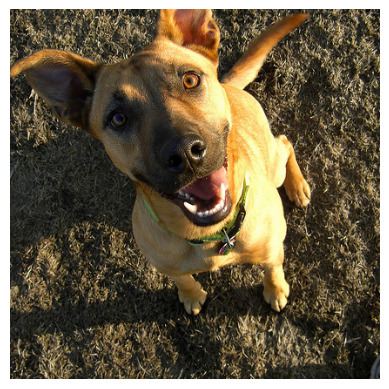

In [8]:
coco_id = 445351

get_image_from_cocoid(coco_id)

print(
    f"Image captions: {stimulus_data[stimulus_data['image_id'] == coco_id]['coco_captions'].iloc[0]}"
)

### fMRI voxel metadata

In [9]:
voxel_metadata.head()

subj_id     ncsnr  EVC  early  ventral  midventral  lateral  \
voxel_id                                                                   
S1-22-11-34        1  0.248737  1.0      0        0           1        0   
S1-22-11-35        1  0.159338  1.0      0        0           1        0   
S1-22-12-33        1  0.145336  1.0      0        0           1        0   
S1-23-10-33        1  0.054892  1.0      0        0           1        0   
S1-23-10-34        1  0.172727  1.0      0        0           1        0   

             midlateral  parietal  midparietal  ...  FFA-2  OFA  EBA  FBA-1  \
voxel_id                                        ...                           
S1-22-11-34           0         0            0  ...    NaN  NaN  NaN    NaN   
S1-22-11-35           0         0            0  ...    NaN  NaN  NaN    NaN   
S1-22-12-33           0         0            0  ...    NaN  NaN  NaN    NaN   
S1-23-10-33           0         0            0  ...    NaN  NaN  NaN    NaN   
S1-23-10-34           0         0            0  ...    NaN  NaN  NaN    NaN   

             FBA-2  OPA  PPA  VWFA-1  VWFA-2  OWFA  
voxel_id                                            
S1-22-11-34    NaN  NaN  NaN     NaN     NaN   NaN  
S1-22-11-35    NaN  NaN  NaN     NaN     NaN   NaN  
S1-22-12-33    NaN  NaN  NaN     NaN     NaN   NaN  
S1-23-10-33    NaN  NaN  NaN     NaN     NaN   NaN  
S1-23-10-34    NaN  NaN  NaN     NaN     NaN   NaN  

[5 rows x 29 columns]

### fMRI response data

In [10]:
print(
    f"There are {response_data.shape[0]} voxels recorded on {response_data.shape[1]} stimulus images"
)
response_data.head()

There are 42384 voxels recorded on 1000 stimulus images


584       605       625       650      1308      1625  \
voxel_id                                                                  
S1-22-11-34  0.752486 -0.297966 -0.108485  0.027122  0.574349 -0.922022   
S1-22-11-35 -0.103754  0.244961  0.504785 -0.929686 -1.126533 -0.101796   
S1-22-12-33 -0.569562  0.082608  0.327680  0.350439 -0.775774 -0.040204   
S1-23-10-33  0.802062  0.366396 -0.060212  0.717037 -0.578445  0.318957   
S1-23-10-34  0.267148 -0.457386  1.764591 -0.621412  0.296390 -0.758162   

                 1877      2270      2349      2372  ...    575701    575971  \
voxel_id                                             ...                       
S1-22-11-34  0.244273 -0.129998 -0.156549 -0.097647  ...  0.811811  0.334647   
S1-22-11-35 -0.451838 -1.169137 -0.005067  0.310044  ...  1.485696  0.213420   
S1-22-12-33 -0.336788 -0.033517  0.059881  0.033386  ... -0.042141  0.052800   
S1-23-10-33  0.177282 -0.390726  0.566761  0.003886  ... -0.649402 -0.205219   
S1-23-10-34 -0.369534 -0.403290 -0.816647 -0.263991  ...  1.237165  0.443143   

               576011    576749    576789    577817    577964    578169  \
voxel_id                                                                  
S1-22-11-34  0.576700 -0.051925  0.960291  1.350665  0.745355 -0.587113   
S1-22-11-35  1.042587 -0.898903 -0.055290  0.927589  0.634646  0.320112   
S1-22-12-33  0.480060  0.420772  0.358667  0.415686  0.425214  0.281323   
S1-23-10-33 -0.324081  0.658013  0.643523  0.038668  0.335630 -0.877173   
S1-23-10-34  1.142742 -0.467000  0.029254  0.263533  0.857254  0.607774   

               579906    580813  
voxel_id                         
S1-22-11-34 -1.248250 -0.684790  
S1-22-11-35  0.194043 -1.279413  
S1-22-12-33 -0.422511 -0.626106  
S1-23-10-33 -1.218459 -0.321058  
S1-23-10-34 -0.189726 -1.609570  

[5 rows x 1000 columns]

### Visualize activity on cortex

Image captions: ['Two giraffes walk along a rocky path, near a tree.', 'Two giraffes walking down a path near some dead trees.', 'The giraffes are walking over the fallen down branches.', ' couple of giraffe walking along a rock covered dirt road.', 'two giraffes some rocks grass dirt and trees']


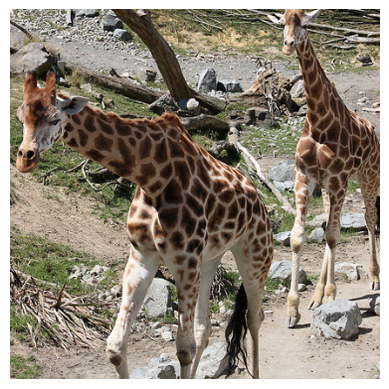

In [11]:
# giraffes
coco_id = 26702

get_image_from_cocoid(coco_id)

print(
    f"Image captions: {stimulus_data[stimulus_data['image_id'] == coco_id]['coco_captions'].iloc[0]}"
)

In [83]:
import nibabel as nib

nsd_path = "/scratch/facosta/NSD"


def get_subj_dims(subj):
    fn = f"{nsd_path}/nsddata/ppdata/{subj}/func1pt8mm/mean.nii.gz"
    return nib.load(fn).get_fdata().shape


subj = "subj01"
space = "func1pt8mm"
xfm = "func1pt8_to_anat0pt8_autoFSbbr"
beta_version = "betas_fithrf_GLMdenoise_RR"

In [84]:
subject_id = 1
regions = rois[subjects[subject_id]]

volumetric_data = np.zeros(get_subj_dims(subj))
volumetric_data[:] = np.nan


for region in regions:
    response = neural_data[subject_id][region]
    for row_i, row in response.iterrows():
        _, x, y, z = row_i.split("-")
        x, y, z = int(x), int(y), int(z)
        volumetric_data[x, y, z] = response.loc[row_i][str(coco_id)]


voxel_data = volumetric_data

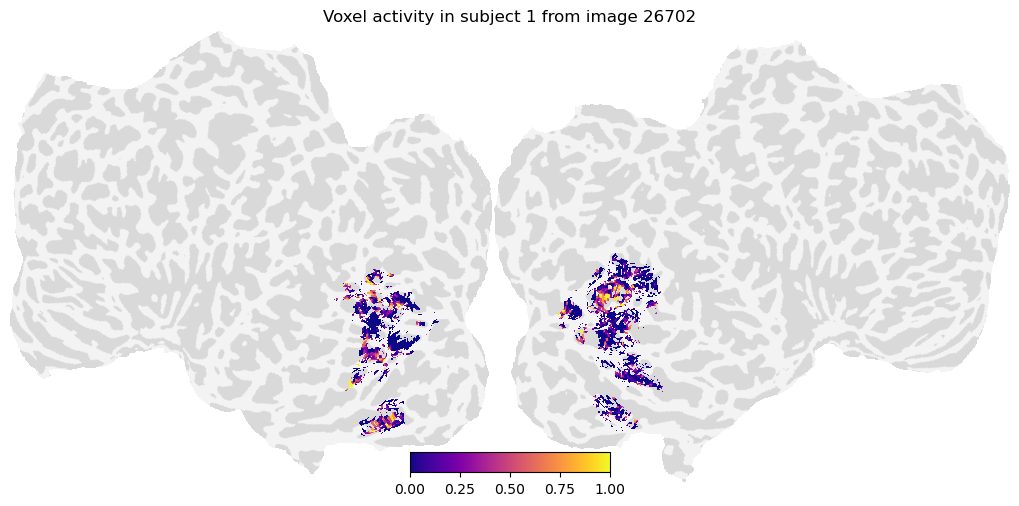

In [85]:
import neurometry.rep_metrics.viz as viz

# Generate the plot_data and fig using plot_ROI_flatmap function
volume, fig = viz.plot_ROI_flatmap(
    voxel_data,
    subj,
    figsize=(10, 5),
    cmap="plasma",
    vmin=0,
    vmax=1.0,  # rois = True,
    title=f"Voxel activity in subject {subject_id} from image {coco_id}",
)

brain_plot = viz.convert_figure_to_image(fig)

## Anatomical Geometry of Visual Cortex

In [87]:
import neurometry.rep_metrics.anatomy as anatomy
import neurometry.rep_metrics.viz as viz

In [98]:
subject = "subj02"

surfs = [cortex.polyutils.Surface(*d) for d in cortex.db.get_surf(subject, "fiducial")]

left, right = surfs

### Visualize Fréchet means & distances between PPA and EBA

/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


Background RRGGBBAA: ffffff00
Area 0:0:2349.34:1024 exported to 2349 x 1024 pixels (96 dpi)


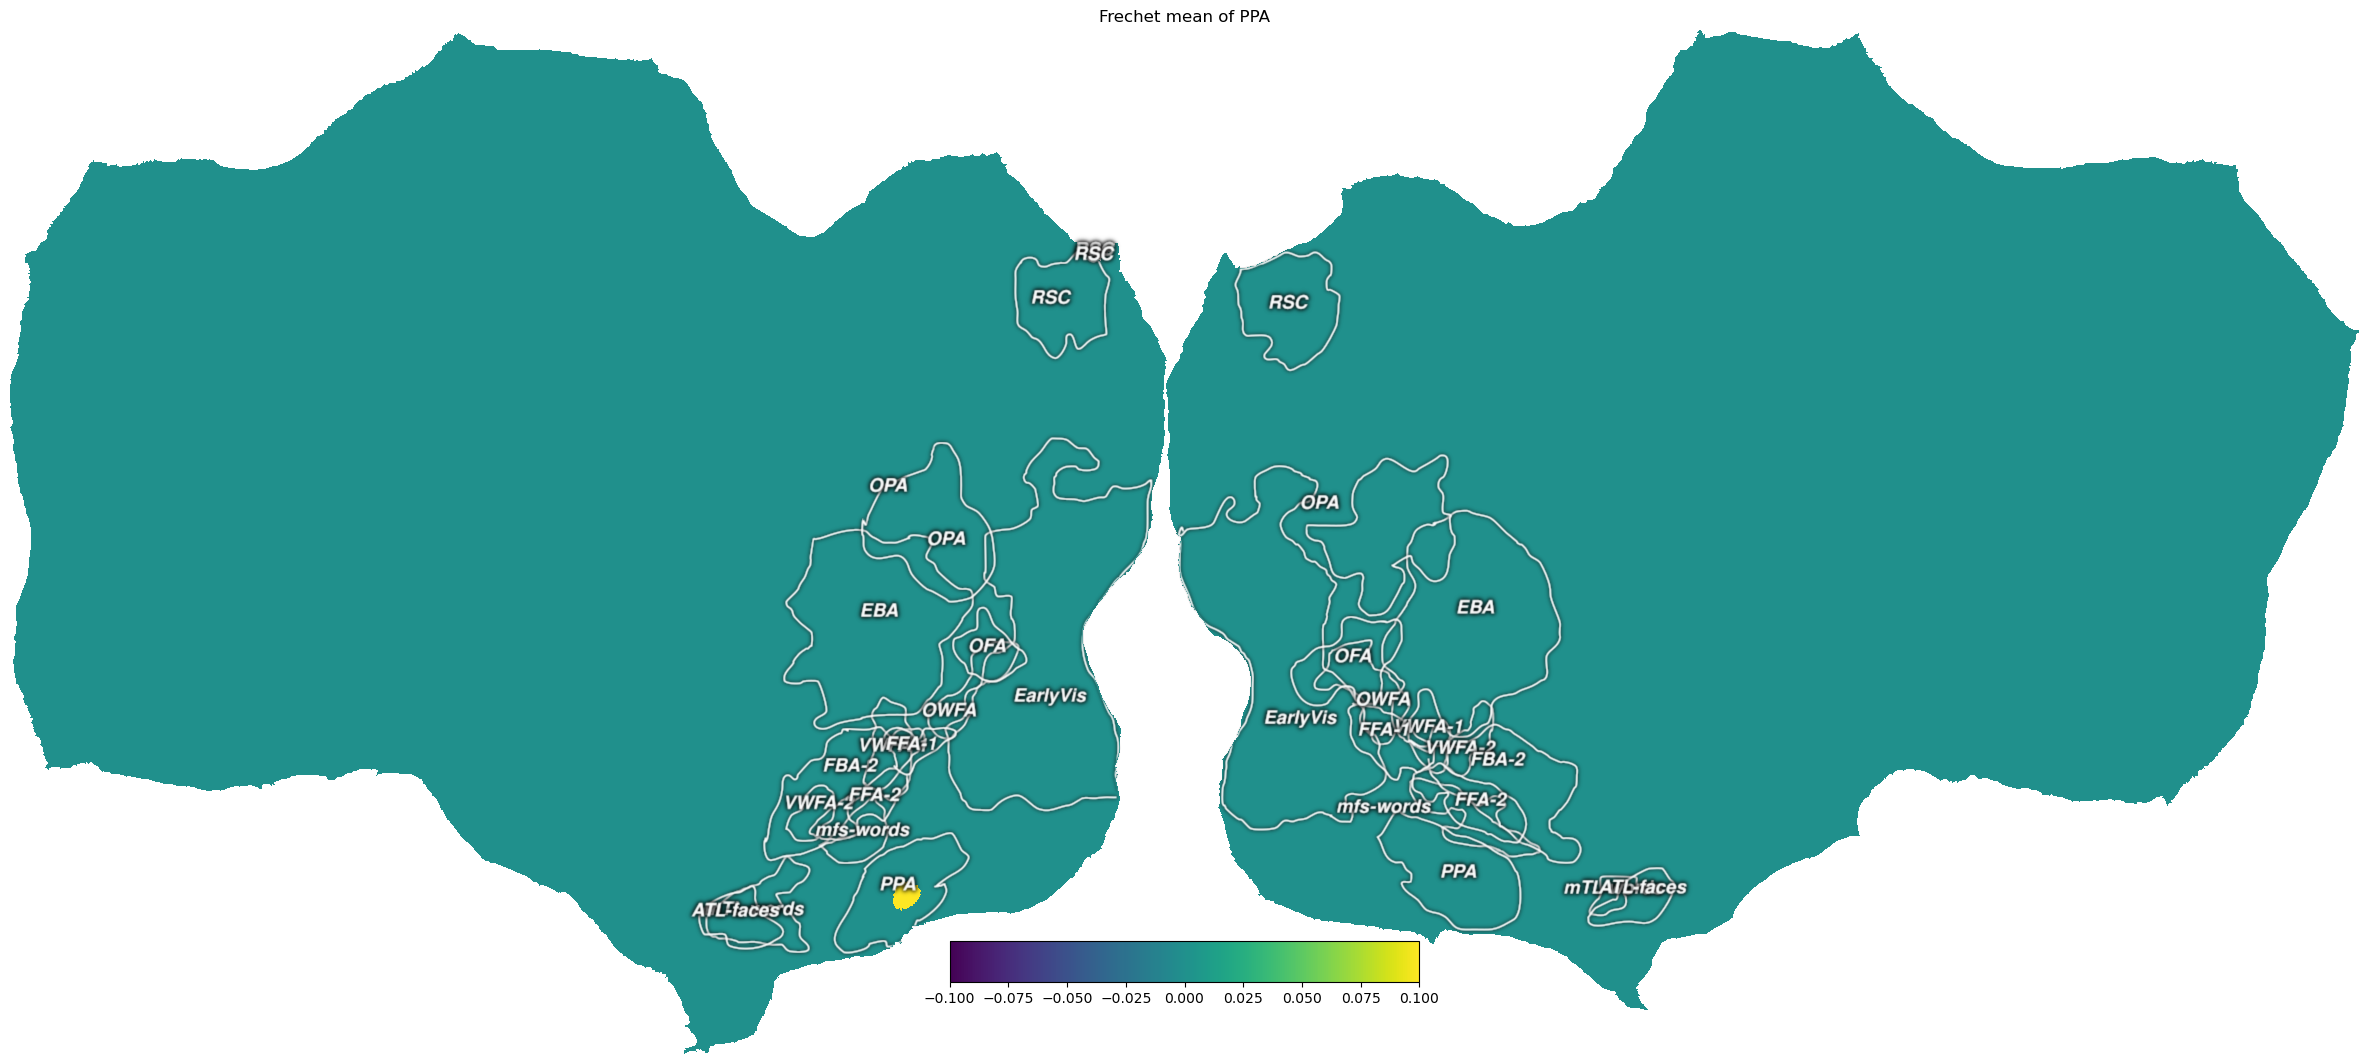

In [99]:
roi = "PPA"

vertex_mask = cortex.get_roi_verts(subject, roi=roi, mask=True)
left_roi_surface = left.create_subsurface(vertex_mask=vertex_mask[roi])
frechet_mean_id = anatomy.compute_frechet_mean(left_roi_surface)
roi_pts_ids = cortex.get_roi_verts(subject, roi=roi)[roi]
PPA_frechet_mean_id_left = anatomy._ids_from_roi_to_hemi(roi_pts_ids, frechet_mean_id)

viz.plot_roi_frechet_mean(subject, left, roi, PPA_frechet_mean_id_left)

/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


Background RRGGBBAA: ffffff00
Area 0:0:2349.34:1024 exported to 2349 x 1024 pixels (96 dpi)


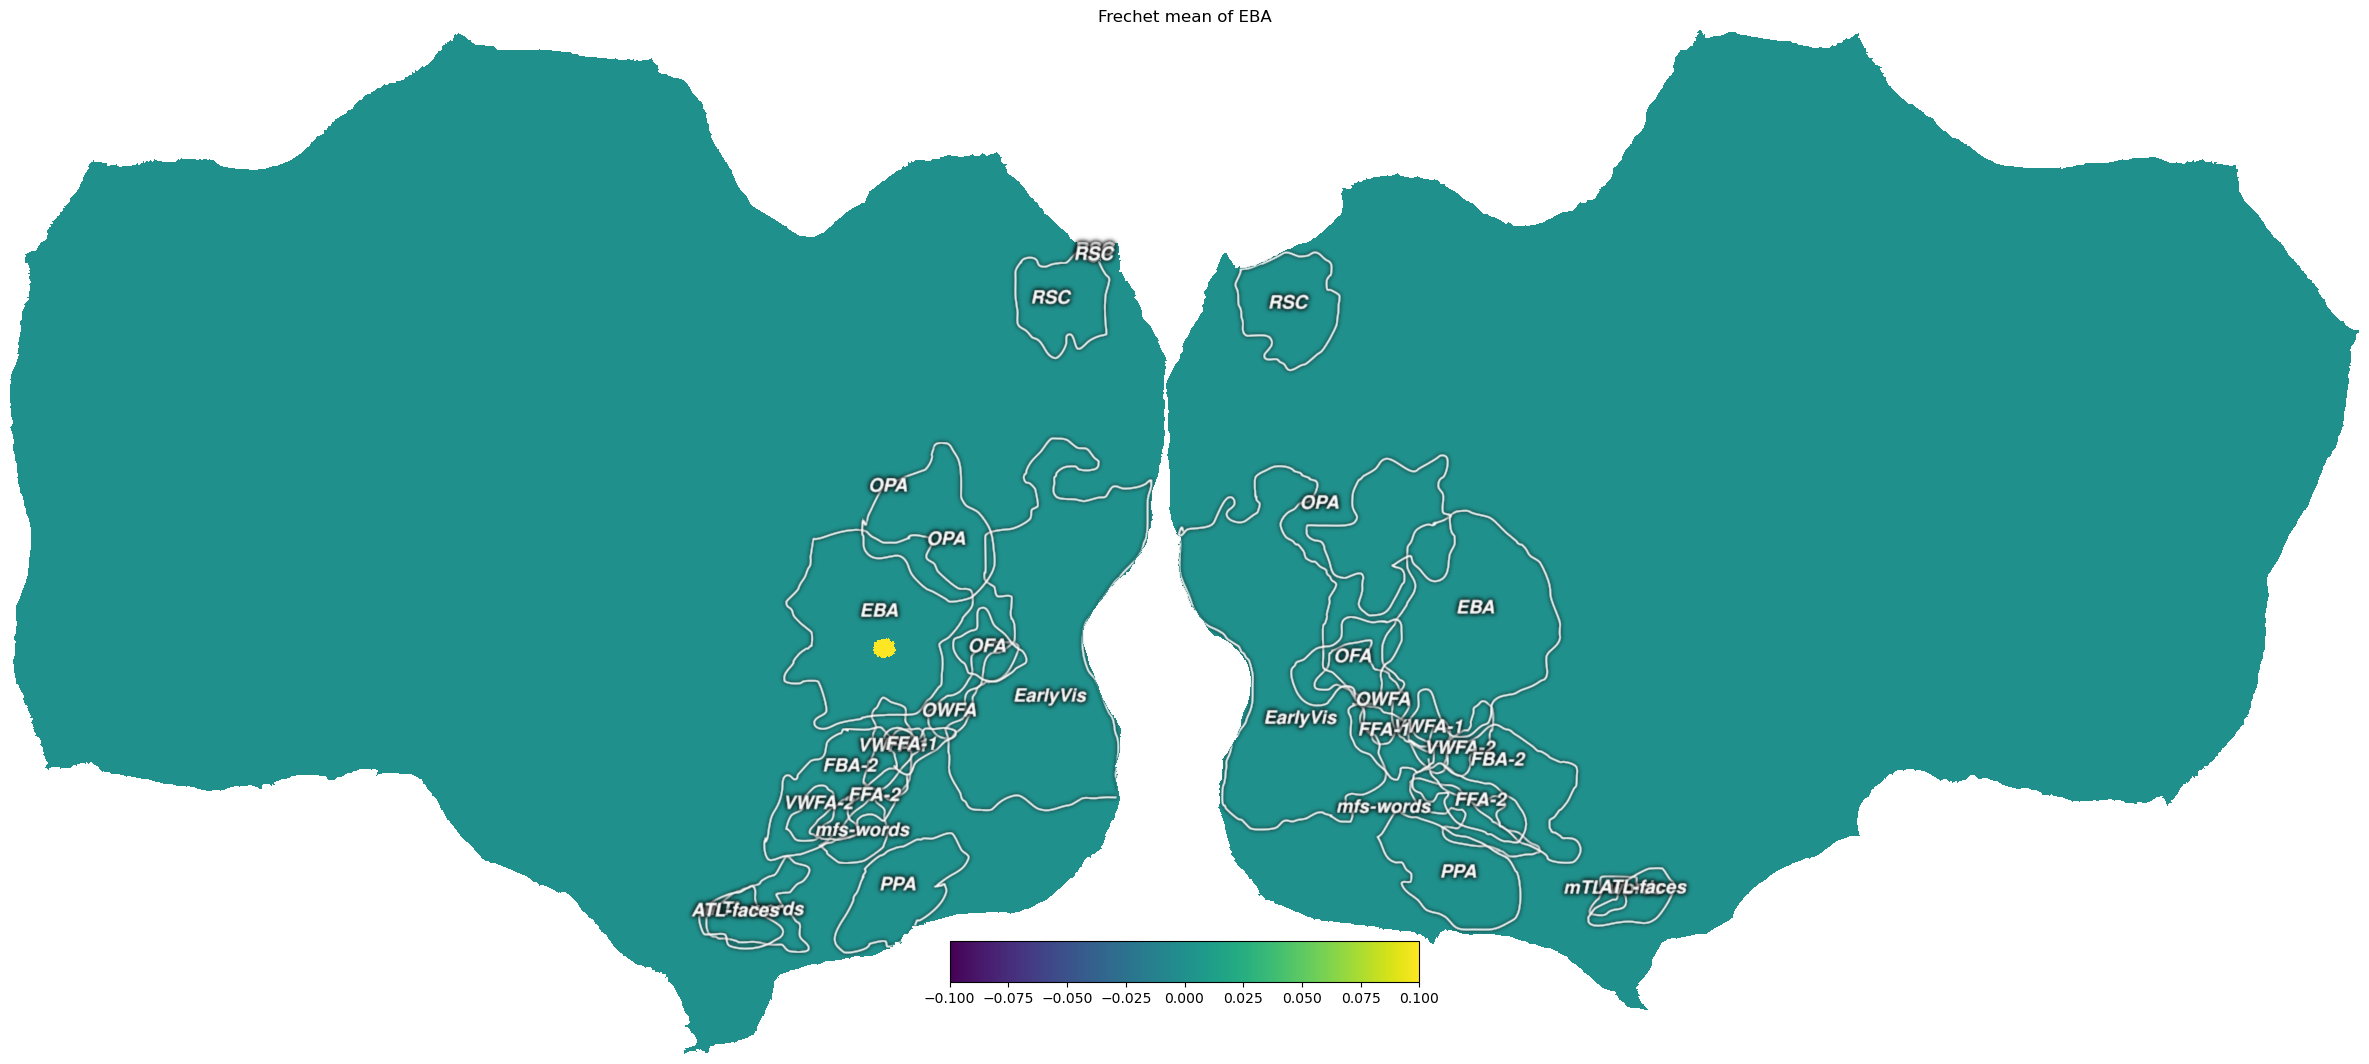

In [90]:
roi = "EBA"

vertex_mask = cortex.get_roi_verts(subject, roi=roi, mask=True)
left_roi_surface = left.create_subsurface(vertex_mask=vertex_mask[roi])
frechet_mean_id = anatomy.compute_frechet_mean(left_roi_surface)
roi_pts_ids = cortex.get_roi_verts(subject, roi=roi)[roi]
EBA_frechet_mean_id_left = anatomy._ids_from_roi_to_hemi(roi_pts_ids, frechet_mean_id)


viz.plot_roi_frechet_mean(subject, left, roi, EBA_frechet_mean_id_left)

/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


Background RRGGBBAA: ffffff00
Area 0:0:2349.34:1024 exported to 2349 x 1024 pixels (96 dpi)


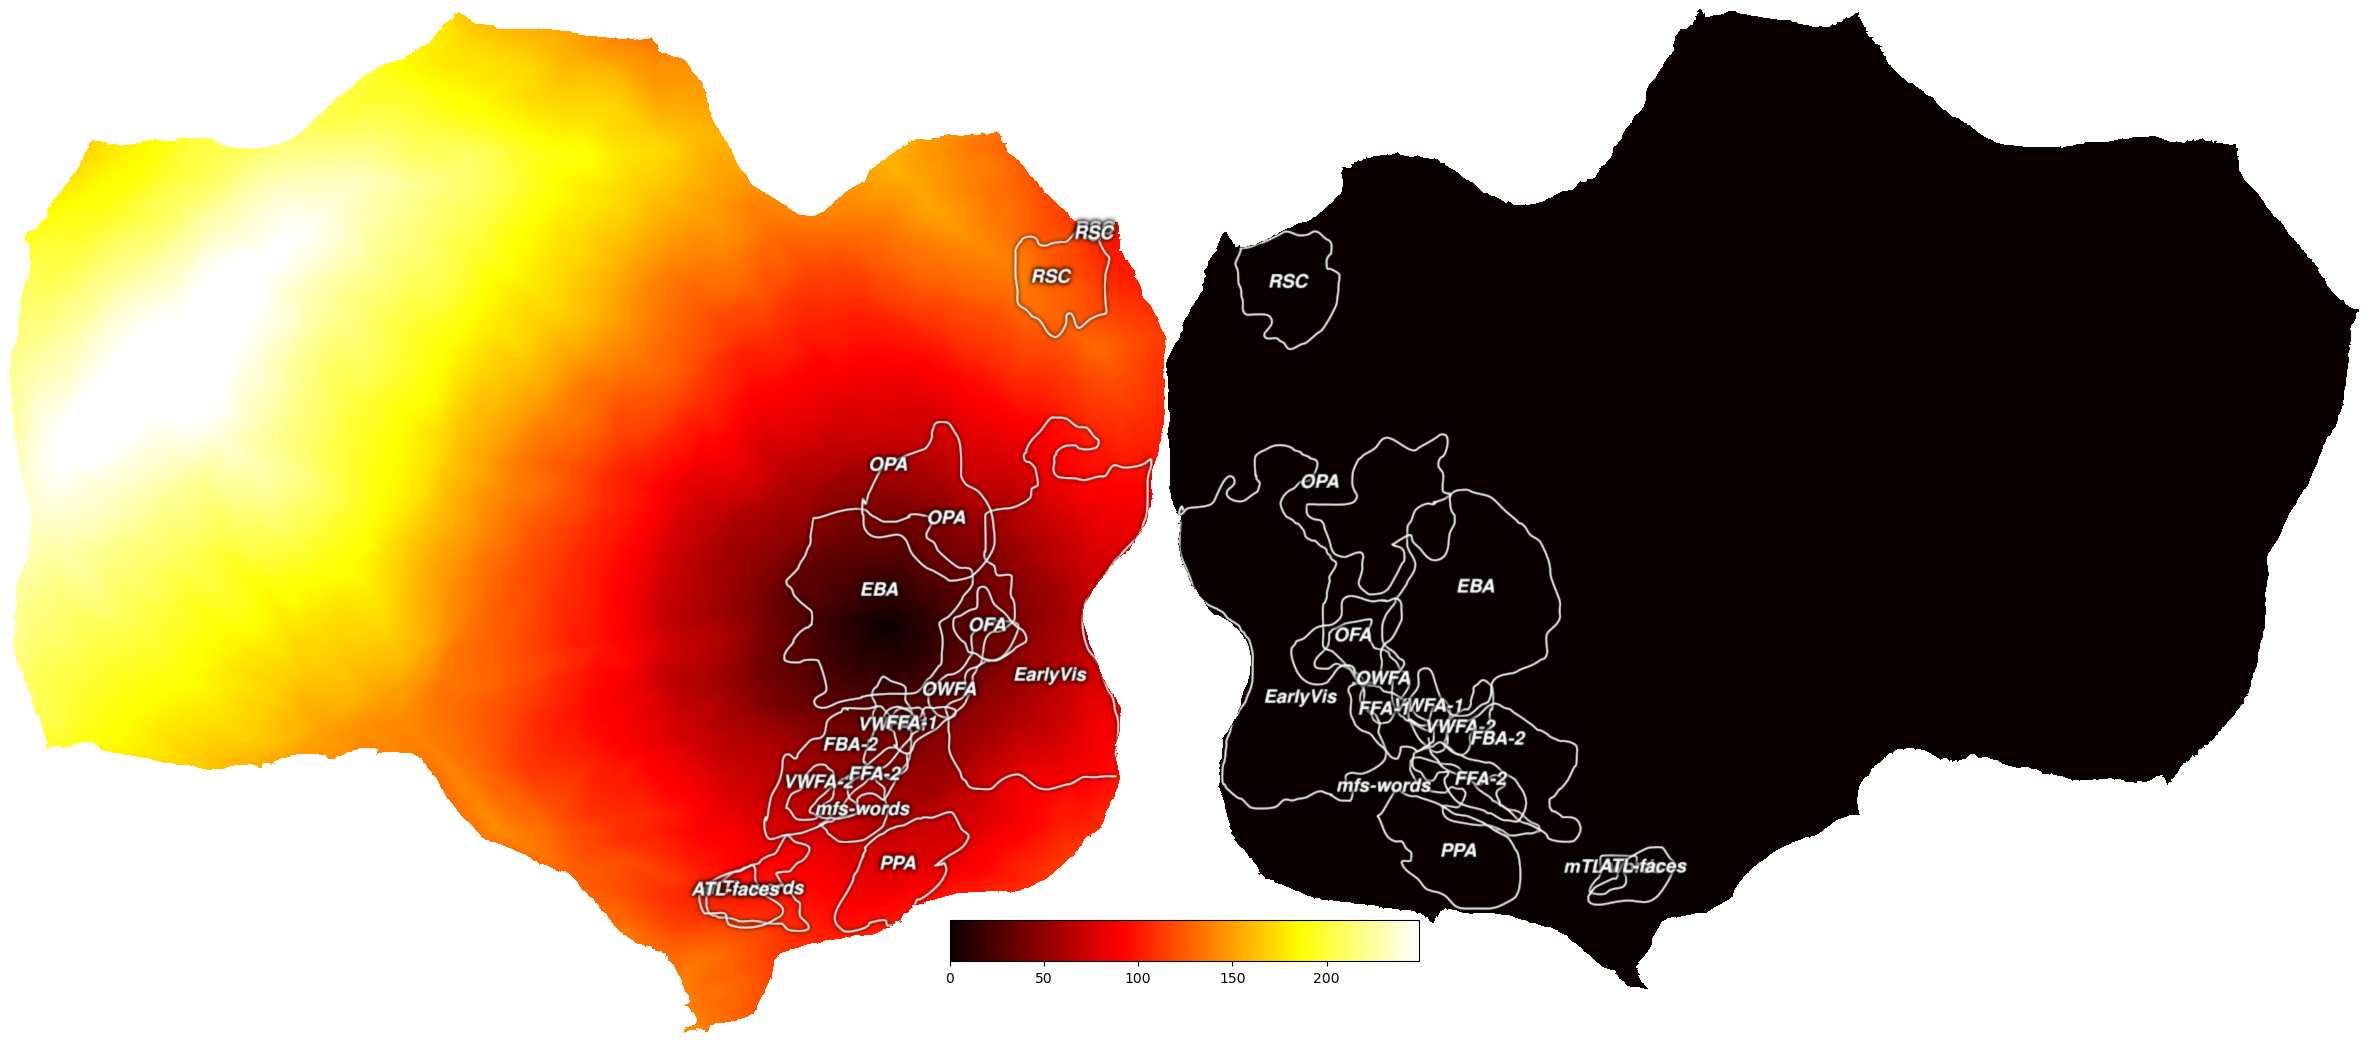

In [91]:
EBA_dists = left.geodesic_distance([EBA_frechet_mean_id_left])
dist_map = cortex.Vertex(EBA_dists, subject, cmap="hot")
cortex.quickshow(dist_map)
plt.show()

Background RRGGBBAA: ffffff00
Area 0:0:2349.34:1024 exported to 2349 x 1024 pixels (96 dpi)


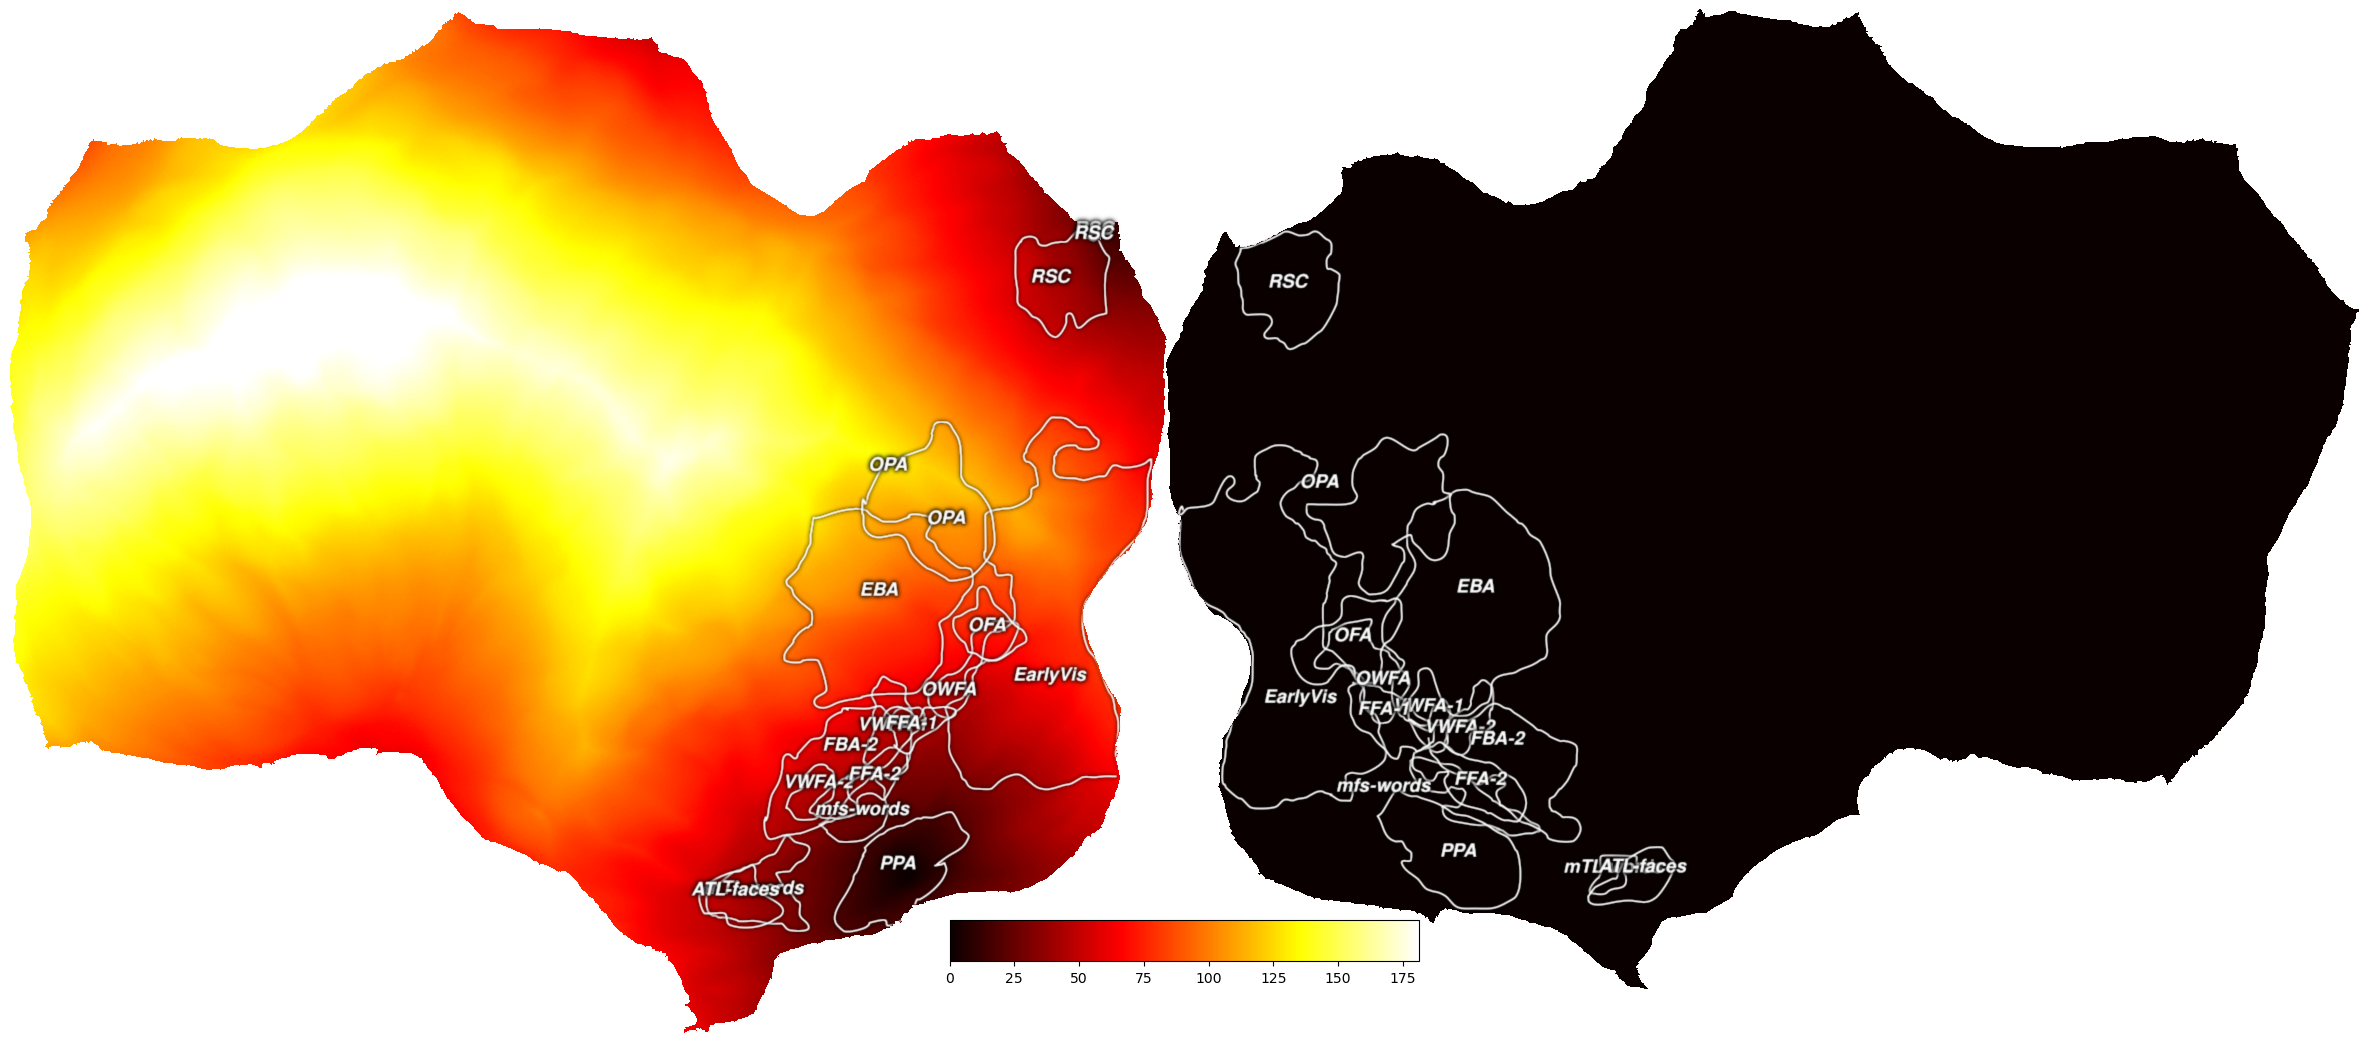

In [92]:
PPA_dists = left.geodesic_distance([PPA_frechet_mean_id_left])
dist_map = cortex.Vertex(PPA_dists, subject, cmap="hot")
cortex.quickshow(dist_map)
plt.show();

In [93]:
print(f"Geodesic distance between PPA and EBA is {PPA_dists[EBA_frechet_mean_id_left]}")

Geodesic distance between PPA and EBA is 82.50075677845354


Background RRGGBBAA: ffffff00
Area 0:0:2349.34:1024 exported to 2349 x 1024 pixels (96 dpi)


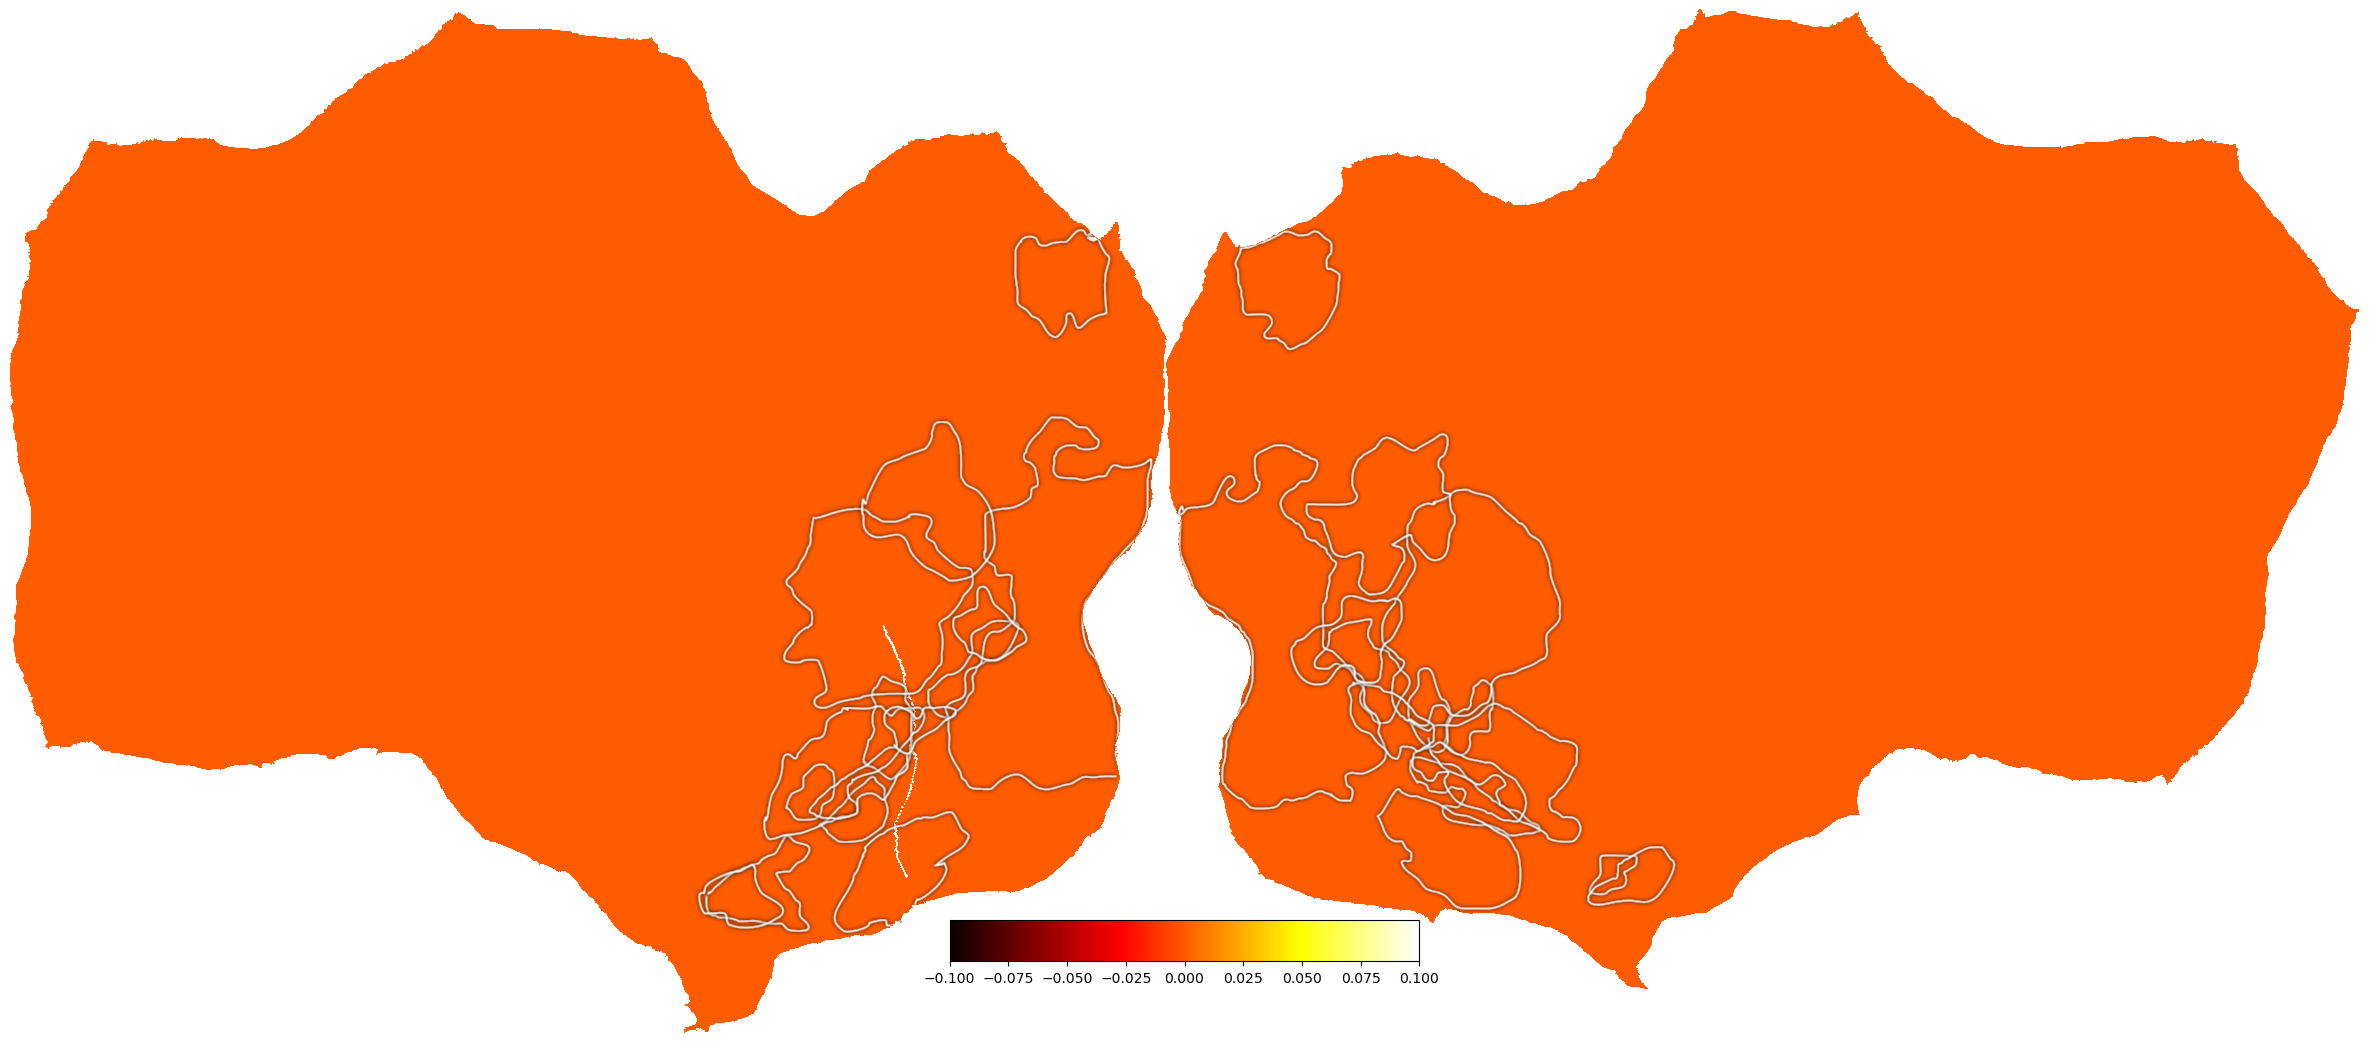

In [94]:
path = left.geodesic_path(PPA_frechet_mean_id_left, EBA_frechet_mean_id_left)
path_data = np.zeros(len(left.pts))
for v in path:
    path_data[v] = 1
EBA_PPA_path_map = cortex.Vertex(path_data, subject, cmap="hot")
cortex.quickshow(EBA_PPA_path_map, with_labels=False)
plt.show()

### FIX: Why is subj01 FFA-2 left surface empty????

In [75]:
vertex_mask = cortex.get_roi_verts("subj01", roi=otc_rois, mask=False)
num_verts = {roi: len(verts) for roi, verts in vertex_mask.items()}
print(num_verts)

{'FFA-1': 1639, 'FFA-2': 1534, 'OFA': 1636, 'EBA': 12407, 'FBA-1': 1451, 'FBA-2': 1865, 'OPA': 7324, 'PPA': 3891, 'VWFA-1': 3448, 'VWFA-2': 1996, 'OWFA': 1684}


In [78]:
roi = "FFA-2"

vertex_mask = cortex.get_roi_verts("subj01", roi=roi, mask=True)
left_roi_surface = left.create_subsurface(vertex_mask=vertex_mask[roi])
print(len(left_roi_surface.pts))

0


In [80]:
roi = "PPA"

vertex_mask = cortex.get_roi_verts("subj01", roi=roi, mask=True)
right_roi_surface = right.create_subsurface(vertex_mask=vertex_mask[roi])
left_roi_surface = left.create_subsurface(vertex_mask=vertex_mask[roi])
print(len(left_roi_surface.pts))
print(len(right_roi_surface.pts))
print(len(left_roi_surface.pts) + len(right_roi_surface.pts))

2150
790
2940


In [93]:
roi = "FFA-2"

vertex_mask = cortex.get_roi_verts("subj01", roi=roi, mask=True)
left_roi_surface = left.create_subsurface(vertex_mask=vertex_mask[roi])
frechet_mean_id = anatomy.compute_frechet_mean(left_roi_surface)
roi_pts_ids = cortex.get_roi_verts(subject, roi=roi)[roi]
FFA2_frechet_mean_id_left = anatomy._ids_from_roi_to_hemi(roi_pts_ids, frechet_mean_id)


viz.plot_roi_frechet_mean(subject, left, roi, FFA2_frechet_mean_id_left)

ValueError: attempt to get argmin of an empty sequence

### Compute all Fréchet means

In [8]:
frechet_means = anatomy.compute_all_frechet_means(subject, left, rois)

computing Frechet mean of FFA-2...


/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


done.
computing Frechet mean of EBA...
done.
computing Frechet mean of VWFA-2...
done.
computing Frechet mean of OFA...
done.
computing Frechet mean of OWFA...
done.
computing Frechet mean of VWFA-1...
done.
computing Frechet mean of FFA-1...
done.
computing Frechet mean of FBA-2...
done.
computing Frechet mean of OPA...
done.
computing Frechet mean of PPA...
done.


In [30]:
anatomical_pairwise_distances = anatomy.compute_cortex_pairwise_geodesic_dist(
    subject, rois, frechet_means
)

Parallelizing n(n-1)/2 = 45 distance calculations with 32 processes.


Computing distances on left cortex:   0%|          | 0/45.0 [00:00<?, ?it/s]/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
Computing distances on left cortex:  29%|██▉       | 13/45.0 [03:09<00:56,  1.75s/it]  /home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/polyutils/surface.py:552: RuntimeWarning: overflow encountered in multiply
  x1 = 0.5 * (c32 * X).sum(1)
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/polyutils/surface.py:553: RuntimeWarning: overflow encountered in multiply
  x2 = 0.5 * (c13 * X).sum(1)
/home/facosta/mi

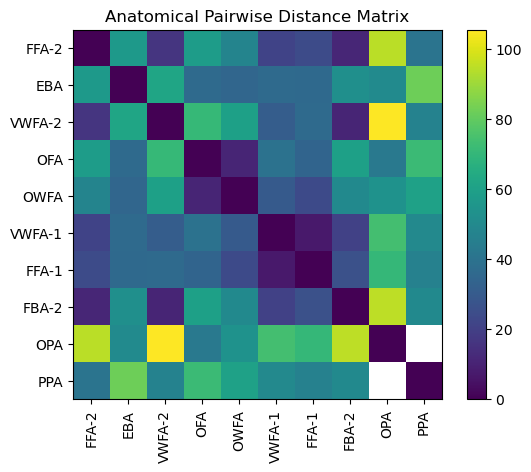

In [35]:
plt.imshow(anatomical_pairwise_distances)
plt.xticks(ticks=np.arange(len(rois)), labels=rois, rotation=90)
plt.yticks(ticks=np.arange(len(rois)), labels=rois)
plt.title(f"Anatomical Pairwise Distance Matrix")
cbar = plt.colorbar()

Why is this nan ?!?!?

In [40]:
anatomic_pairwise_distances[9, 8]

nan

In [86]:
subject = "subj01"
roi = "FFA-2"

left_rois_vertices, right_rois_vertices = anatomy.get_roi_vertices(subject, otc_rois)

roi_pts_ids = left_rois_vertices[roi]
roi_pts = left.pts[roi_pts_ids]

# ROI polys in hemisphere indices
roi_polys = [
    face
    for face in left.polys
    if (face[0] in roi_pts_ids and face[1] in roi_pts_ids and face[2] in roi_pts_ids)
]

# ROI polys in ROI indices
roi_polys_in_roi = [
    (
        anatomy._ids_from_hemi_to_roi(roi_pts_ids, face[0]),
        anatomy._ids_from_hemi_to_roi(roi_pts_ids, face[1]),
        anatomy._ids_from_hemi_to_roi(roi_pts_ids, face[2]),
    )
    for face in roi_polys
]

roi_surface = cortex.utils.Surface(pts=roi_pts, polys=np.array(roi_polys_in_roi))

frechet_mean_id = anatomy.compute_frechet_mean(left_roi_surface)
roi_pts_ids = cortex.get_roi_verts(subject, roi=roi)[roi]
frechet_mean_id_left = anatomy._ids_from_roi_to_hemi(roi_pts_ids, frechet_mean_id)

anatomy.plot_roi_frechet_mean(subject, left, roi, frechet_mean_id_left)

IndexError: index 317736 is out of bounds for axis 0 with size 227021

## Representational Similarity Analysis (RSA) 

In [17]:
import neurometry.rep_metrics.dissimilarity as dissimilarity

Compute RDMs (pearson) for all $n$ networks and compute $\frac{1}{2}n(n-1)$ pairwise dissimilarities (1-pearson)

Parallelizing n(n-1)/2 = 153 distance calculations with 32 processes.


Computing distances: 100%|██████████| 153/153.0 [00:00<00:00, 209.90it/s]


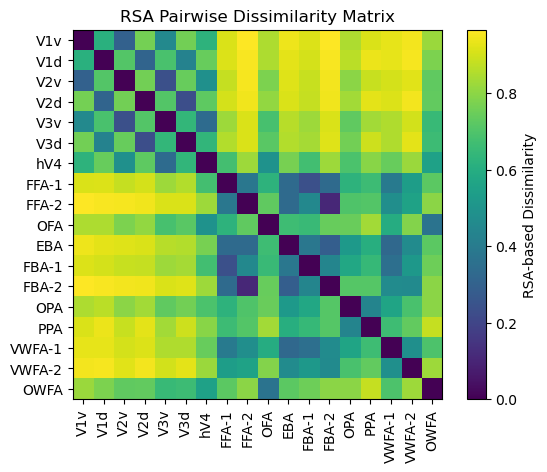

In [21]:
rsa_pairwise_dissimilarity_matrix = dissimilarity.compute_rsa_pairwise_dissimilarities(
    neural_data[1], "pearson", "pearson"
)

viz.plot_pairwise_dis_matrix(rsa_pairwise_dissimilarity_matrix, functional_rois, "RSA")

In [1]:
import itertools

rdm_compute_types = ["euclidean", "pearson", "spearman", "mahalanobis", "concordance"]
rdm_compare_types = ["pearson", "spearman", "concordance"]
rsa_types = list(itertools.product(rdm_compute_types, rdm_compare_types))

## Principal Component Analysis (PCA) of Voxel Responses

Plot PCA eigenspectrum for one region - e.g., Human V4

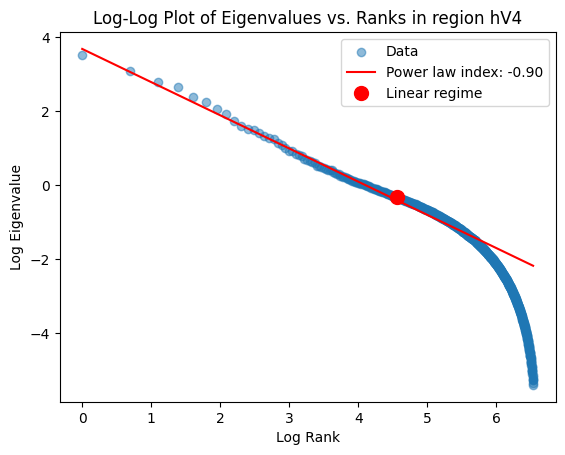

In [24]:
from neurometry.rep_metrics.dim_reduction import compute_power_law_index

region = "hV4"

slope, y_intercept, log_ranks, log_eigvals, knee_x, knee_y = compute_power_law_index(
    neural_data[region].to_numpy()
)

import viz

viz.plot_pca_spectrum(
    region, slope, y_intercept, log_ranks, log_eigvals, knee_x, knee_y
)

### Quantify geometric distortion introduced by PCA projection 

Plot cumulative variance explained ratio vs principal component dimensions

In [53]:
from neurometry.rep_metrics.dim_reduction import TorchPCA
from neurometry.rep_metrics.dissimilarity import shape_preprocess

PCAing neural data for shape metrics analysis...
done!


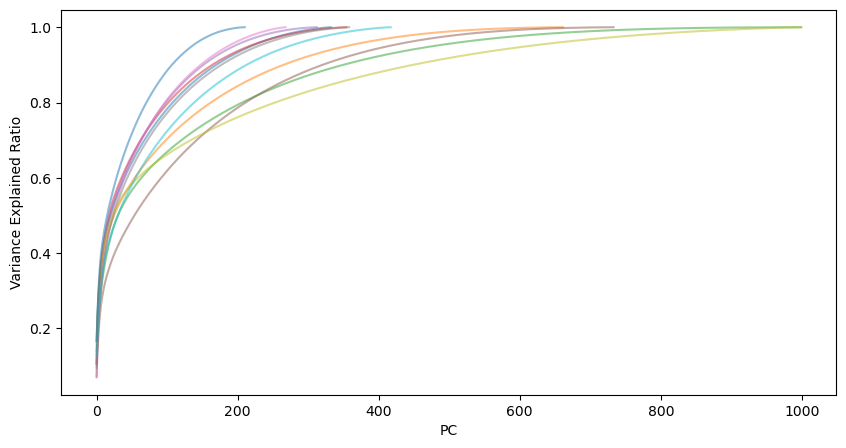

In [54]:
pca_neural_data, pcas = shape_preprocess(neural_data, subjects, rois)

fig = plt.figure(figsize=(10, 5))
for region in rois["subj01"]:
    plt.plot(pcas[1][region].cumulative_explained_variance_ratio_.cpu(), alpha=0.5)
    plt.xlabel("PC")
    plt.ylabel("Variance Explained Ratio")

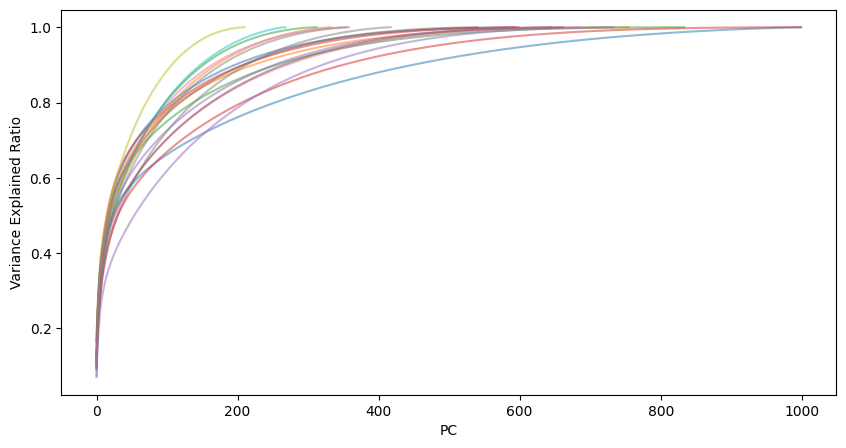

In [25]:
fig = plt.figure(figsize=(10, 5))
neural_data_region_pcas = {}
for region in functional_rois:
    pca = TorchPCA(device="cuda").fit(neural_data[region].to_numpy())
    neural_data_region_pcas[region] = pca
    plt.plot(pca.cumulative_explained_variance_ratio_.cpu(), alpha=0.5)
    plt.xlabel("PC")
    plt.ylabel("Variance Explained Ratio")

Analyze within-region pairwise-distance preservation

In [26]:
neural_data_list = [neural_data[region].to_numpy().T for region in neural_data.keys()]

In [28]:
from neurometry.rep_metrics.dim_reduction import compute_distance_preservation

corrs, stresses, all_us = compute_distance_preservation(neural_data_list)

100%|██████████| 211/211 [00:13<00:00, 15.99it/s]


correlation >= 0.95 at dim 5
stress <= 0.15 not attainable


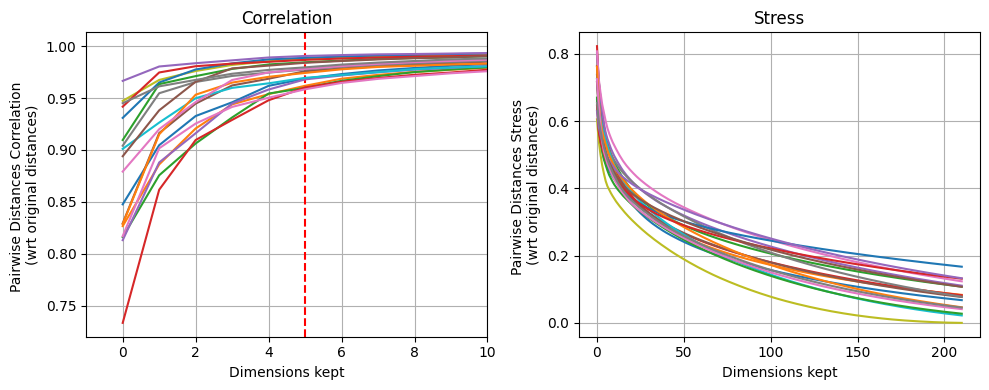

In [29]:
from neurometry.rep_metrics.dim_reduction import get_minimal_embedding

corr_reduced_neural_data, stress_reduced_neural_data = get_minimal_embedding(
    corrs, stresses, all_us, plot=True, corr_threshold=0.95, stress_threshold=0.15
)

viz.plot_pca_distortions(
    corrs, stresses, corrs_dim=corr_reduced_neural_data[0].shape[1]
)

### Perform PCA reduction with fixed n_components for all regions

In [30]:
n_components = 211

pca_reduced_neural_data = {}

for region in functional_rois:
    X = (
        neural_data_region_pcas[region]
        .get_top_n_components(n_components=n_components)
        .T
    )
    pca_reduced_neural_data[region] = pd.DataFrame(
        X.cpu(), columns=neural_data[region].columns
    )

## Generalized Shape Metrics

### Initialize metric

We choose a metric from a family of linear metrics parameterized by $\alpha \in [0,1]$, where

$\alpha = 0$ corresponds to [Canonical Correlation Analysis (CCA)](https://en.wikipedia.org/wiki/Canonical_correlation)

$\alpha = 1$ corresponds to [Procrustes distance](https://en.wikipedia.org/wiki/Procrustes_analysis)

### Compute region-region pairwise distance matrix

We have n = 18 cortical regions;
We need n(n-1)/2 = 153 distance calculations
Parallelizing 153 distance calculations with 32 processes.


Computing distances: 100%|██████████| 153/153 [00:11<00:00, 13.80it/s]


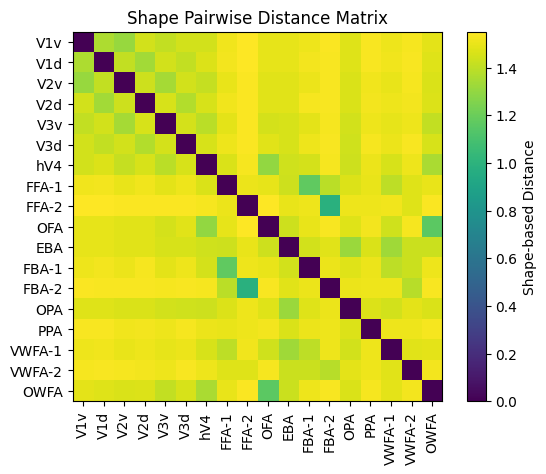

In [33]:
alpha = 1  # Procrustes

shape_pairwise_distance_matrix = dissimilarity.compute_shape_pairwise_distances(
    pca_reduced_neural_data, stimulus_data, alpha=alpha
)
viz.plot_pairwise_dis_matrix(dissimilarity.pairwise_distance_matrix, functional_rois, method="Shape")

## Centered Kernel Alignment (CKA)

In [1]:
import sys
sys.path.append("../")
sys.path.append("../neurometry/rep_metrics/")
import neurometry.rep_metrics.main as main

cka_final_matrices = main.cka_pairwise_matrices()

Now loading the shared1000 image set and the OTC-only voxel set...
Now loading the shared1000 image set and the EVC-only voxel set...


/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (floc-bodies) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (floc-faces) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (prf_angle) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (floc-words) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.na

Subject 2 has 274 voxels in region FFA-1
Subject 2 has 1081 voxels in region OPA
Subject 2 has 288 voxels in region OFA
Subject 2 has 783 voxels in region FBA-2
Subject 2 has 2562 voxels in region EBA
Subject 2 has 352 voxels in region OWFA
Subject 2 has 343 voxels in region FFA-2
Subject 2 has 165 voxels in region VWFA-2
Subject 2 has 287 voxels in region VWFA-1
Subject 2 has 749 voxels in region PPA
PCAing neural data for shape metrics analysis...
done!
Computing RSA linear_cka pairwise dissimilarities for subject subj02...
Parallelizing n(n-1)/2 = 45 distance calculations with 32 processes.


Computing distances: 100%|██████████| 45/45.0 [00:00<00:00, 516.03it/s]


done!
Computing RSA kernel_cka pairwise dissimilarities for subject subj02...
Parallelizing n(n-1)/2 = 45 distance calculations with 32 processes.


Computing distances: 100%|██████████| 45/45.0 [00:00<00:00, 184.97it/s]

done!
finished CKA for subjectsubj02.
-----finished CKA computations for all subjects-----


## Compute Anatomical Stress Score for all Representational Metrics

Why does spearman_spearman RSA take FOREVER???

In [1]:
import sys
sys.path.append("../")
sys.path.append("../neurometry/rep_metrics/")
import neurometry.rep_metrics.config as config
import neurometry.rep_metrics.main as main
rsa_final_matrices = main.rsa_pairwise_matrices()
#shape_final_matrices = main.shape_pairwise_matrices()
#anatomy_final_matrices = main.anatomical_distance_matrices()
#cka_final_matrices = main.cka_pairwise_matrices()

Now loading the shared1000 image set and the OTC-only voxel set...


/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (floc-places) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (floc-faces) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (floc-bodies) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (prf-visualrois) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%s

Subject 1 has 734 voxels in region PPA
Subject 1 has 333 voxels in region FBA-1
Subject 1 has 418 voxels in region FFA-1
Subject 1 has 2525 voxels in region EBA
Subject 1 has 359 voxels in region OWFA
Subject 1 has 269 voxels in region OFA
Subject 1 has 211 voxels in region FFA-2
Subject 1 has 662 voxels in region VWFA-1
Subject 1 has 355 voxels in region VWFA-2
Subject 1 has 313 voxels in region FBA-2
Subject 1 has 1173 voxels in region OPA
Subject 2 has 749 voxels in region PPA
Subject 2 has 274 voxels in region FFA-1
Subject 2 has 2562 voxels in region EBA
Subject 2 has 352 voxels in region OWFA
Subject 2 has 288 voxels in region OFA
Subject 2 has 343 voxels in region FFA-2
Subject 2 has 287 voxels in region VWFA-1
Subject 2 has 165 voxels in region VWFA-2
Subject 2 has 783 voxels in region FBA-2
Subject 5 has 948 voxels in region PPA
Subject 5 has 404 voxels in region FBA-1
Subject 5 has 382 voxels in region FFA-1
Subject 5 has 3354 voxels in region EBA
Subject 5 has 387 voxels in 

/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


done.
computing Frechet mean of FBA-1...
done.
computing Frechet mean of FFA-1...
done.
computing Frechet mean of EBA...
done.
computing Frechet mean of OWFA...
done.
computing Frechet mean of OFA...
done.
computing Frechet mean of FFA-2...
skipping...
computing Frechet mean of VWFA-1...
done.
computing Frechet mean of VWFA-2...
done.
computing Frechet mean of FBA-2...
skipping...
computing Frechet mean of OPA...
done.
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances on left cortex: 100%|██████████| 36/36.0 [05:42<00:00,  9.51s/it]  


done!
Computing anatomical pairwise distance for subject subj02...
computing Frechet mean of PPA...


/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


done.
computing Frechet mean of FFA-1...
done.
computing Frechet mean of EBA...
done.
computing Frechet mean of OWFA...
done.
computing Frechet mean of OFA...
done.
computing Frechet mean of FFA-2...
done.
computing Frechet mean of VWFA-1...
done.
computing Frechet mean of VWFA-2...
done.
computing Frechet mean of FBA-2...
done.
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances on left cortex: 100%|██████████| 36/36.0 [06:24<00:00, 10.69s/it]  


done!
Computing anatomical pairwise distance for subject subj05...
computing Frechet mean of PPA...


/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


done.
computing Frechet mean of FBA-1...
done.
computing Frechet mean of FFA-1...
done.
computing Frechet mean of EBA...
done.
computing Frechet mean of OWFA...
done.
computing Frechet mean of OFA...
done.
computing Frechet mean of FFA-2...
done.
computing Frechet mean of VWFA-1...
done.
computing Frechet mean of VWFA-2...
done.
computing Frechet mean of FBA-2...
done.
computing Frechet mean of OPA...
done.
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances on left cortex: 100%|██████████| 55/55.0 [03:55<00:00,  4.28s/it]  


done!
Computing anatomical pairwise distance for subject subj07...
computing Frechet mean of PPA...


/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


done.
computing Frechet mean of FFA-1...
done.
computing Frechet mean of EBA...
done.
computing Frechet mean of OFA...
done.
computing Frechet mean of FFA-2...
done.
computing Frechet mean of OPA...
done.
Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances on left cortex: 100%|██████████| 15/15.0 [01:54<00:00,  7.66s/it]


done!
-----finished anatomical computations for all subjects-----
PCAing neural data for shape metrics analysis...
done!
Computing RSA euclidean_pearson pairwise dissimilarities for subject subj01...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 87.44it/s]


done!
Computing RSA euclidean_spearman pairwise dissimilarities for subject subj01...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:01<00:00, 26.16it/s]


done!
Computing RSA euclidean_concordance pairwise dissimilarities for subject subj01...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 237.89it/s]

done!
Computing RSA pearson_pearson pairwise dissimilarities for subject subj01...


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 157.97it/s]


done!
Computing RSA pearson_spearman pairwise dissimilarities for subject subj01...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:01<00:00, 29.07it/s]


done!
Computing RSA pearson_concordance pairwise dissimilarities for subject subj01...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 254.23it/s]

done!
Computing RSA spearman_pearson pairwise dissimilarities for subject subj01...


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 205.42it/s]

done!
Computing RSA spearman_concordance pairwise dissimilarities for subject subj01...


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 205.62it/s]


done!
Computing RSA mahalanobis_pearson pairwise dissimilarities for subject subj01...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 143.45it/s]


done!
Computing RSA mahalanobis_spearman pairwise dissimilarities for subject subj01...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:01<00:00, 34.97it/s]


done!
Computing RSA mahalanobis_concordance pairwise dissimilarities for subject subj01...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 273.44it/s]

done!
Computing RSA concordance_pearson pairwise dissimilarities for subject subj01...


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 220.65it/s]

done!
Computing RSA concordance_spearman pairwise dissimilarities for subject subj01...


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:01<00:00, 35.06it/s]


done!
Computing RSA concordance_concordance pairwise dissimilarities for subject subj01...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 272.93it/s]

done!
finished RSA for subjectsubj01.
Computing RSA euclidean_pearson pairwise dissimilarities for subject subj02...


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 260.45it/s]

done!
Computing RSA euclidean_spearman pairwise dissimilarities for subject subj02...


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 36.99it/s]


done!
Computing RSA euclidean_concordance pairwise dissimilarities for subject subj02...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 282.40it/s]

done!
Computing RSA pearson_pearson pairwise dissimilarities for subject subj02...


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 151.22it/s]


done!
Computing RSA pearson_spearman pairwise dissimilarities for subject subj02...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:02<00:00, 13.17it/s]


done!
Computing RSA pearson_concordance pairwise dissimilarities for subject subj02...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 250.57it/s]

done!
Computing RSA spearman_pearson pairwise dissimilarities for subject subj02...


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 253.71it/s]

done!
Computing RSA spearman_concordance pairwise dissimilarities for subject subj02...


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 241.05it/s]

done!
Computing RSA mahalanobis_pearson pairwise dissimilarities for subject subj02...


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 73.67it/s]


done!
Computing RSA mahalanobis_spearman pairwise dissimilarities for subject subj02...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:01<00:00, 25.34it/s]


done!
Computing RSA mahalanobis_concordance pairwise dissimilarities for subject subj02...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 268.26it/s]

done!
Computing RSA concordance_pearson pairwise dissimilarities for subject subj02...


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 176.94it/s]


done!
Computing RSA concordance_spearman pairwise dissimilarities for subject subj02...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:03<00:00, 11.27it/s]


done!
Computing RSA concordance_concordance pairwise dissimilarities for subject subj02...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 178.67it/s]


done!
finished RSA for subjectsubj02.
Computing RSA euclidean_pearson pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:00<00:00, 222.26it/s]


done!
Computing RSA euclidean_spearman pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:01<00:00, 35.01it/s]


done!
Computing RSA euclidean_concordance pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:00<00:00, 183.60it/s]


done!
Computing RSA pearson_pearson pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:00<00:00, 211.62it/s]


done!
Computing RSA pearson_spearman pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:01<00:00, 36.21it/s]


done!
Computing RSA pearson_concordance pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:00<00:00, 216.09it/s]


done!
Computing RSA spearman_pearson pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:00<00:00, 216.97it/s]


done!
Computing RSA spearman_concordance pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:00<00:00, 279.11it/s]


done!
Computing RSA mahalanobis_pearson pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:00<00:00, 118.10it/s]


done!
Computing RSA mahalanobis_spearman pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:01<00:00, 32.05it/s]


done!
Computing RSA mahalanobis_concordance pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:00<00:00, 302.11it/s]

done!
Computing RSA concordance_pearson pairwise dissimilarities for subject subj05...


Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:00<00:00, 169.79it/s]


done!
Computing RSA concordance_spearman pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:01<00:00, 30.53it/s]


done!
Computing RSA concordance_concordance pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:00<00:00, 268.27it/s]


done!
finished RSA for subjectsubj05.
Computing RSA euclidean_pearson pairwise dissimilarities for subject subj07...
Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 155.59it/s]

done!
Computing RSA euclidean_spearman pairwise dissimilarities for subject subj07...


Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 34.58it/s]


done!
Computing RSA euclidean_concordance pairwise dissimilarities for subject subj07...
Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 246.96it/s]

done!
Computing RSA pearson_pearson pairwise dissimilarities for subject subj07...


Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 185.67it/s]

done!
Computing RSA pearson_spearman pairwise dissimilarities for subject subj07...


Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 33.16it/s]


done!
Computing RSA pearson_concordance pairwise dissimilarities for subject subj07...
Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 223.29it/s]

done!
Computing RSA spearman_pearson pairwise dissimilarities for subject subj07...


Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 200.91it/s]

done!
Computing RSA spearman_concordance pairwise dissimilarities for subject subj07...


Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 207.29it/s]

done!
Computing RSA mahalanobis_pearson pairwise dissimilarities for subject subj07...


Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 174.59it/s]

done!
Computing RSA mahalanobis_spearman pairwise dissimilarities for subject subj07...


Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 35.37it/s]


done!
Computing RSA mahalanobis_concordance pairwise dissimilarities for subject subj07...
Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 234.81it/s]

done!
Computing RSA concordance_pearson pairwise dissimilarities for subject subj07...


Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 97.21it/s]


done!
Computing RSA concordance_spearman pairwise dissimilarities for subject subj07...
Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 37.64it/s]


done!
Computing RSA concordance_concordance pairwise dissimilarities for subject subj07...
Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 242.22it/s]

done!
finished RSA for subjectsubj07.
-----finished RSA computations for all subjects-----
Computing Shape Metric (alpha=0) pairwise dissimilarities for subject subj01...
We have n = 9 cortical regions;
We need n(n-1)/2 = 36 distance calculations
Parallelizing 36 distance calculations with 32 processes.



Computing distances: 100%|██████████| 36/36 [00:04<00:00,  7.24it/s]


done!
Computing Shape Metric (alpha=0.5) pairwise dissimilarities for subject subj01...
We have n = 9 cortical regions;
We need n(n-1)/2 = 36 distance calculations
Parallelizing 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36 [00:04<00:00,  7.80it/s]


done!
Computing Shape Metric (alpha=1) pairwise dissimilarities for subject subj01...
We have n = 9 cortical regions;
We need n(n-1)/2 = 36 distance calculations
Parallelizing 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36 [00:02<00:00, 12.97it/s]


done!
finished shape metrics for subject subj01.
Computing Shape Metric (alpha=0) pairwise dissimilarities for subject subj02...
We have n = 9 cortical regions;
We need n(n-1)/2 = 36 distance calculations
Parallelizing 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36 [00:01<00:00, 18.51it/s]


done!
Computing Shape Metric (alpha=0.5) pairwise dissimilarities for subject subj02...
We have n = 9 cortical regions;
We need n(n-1)/2 = 36 distance calculations
Parallelizing 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36 [00:01<00:00, 18.65it/s]


done!
Computing Shape Metric (alpha=1) pairwise dissimilarities for subject subj02...
We have n = 9 cortical regions;
We need n(n-1)/2 = 36 distance calculations
Parallelizing 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36 [00:01<00:00, 26.23it/s]


done!
finished shape metrics for subject subj02.
Computing Shape Metric (alpha=0) pairwise dissimilarities for subject subj05...
We have n = 11 cortical regions;
We need n(n-1)/2 = 55 distance calculations
Parallelizing 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


done!
Computing Shape Metric (alpha=0.5) pairwise dissimilarities for subject subj05...
We have n = 11 cortical regions;
We need n(n-1)/2 = 55 distance calculations
Parallelizing 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55 [00:04<00:00, 12.90it/s]


done!
Computing Shape Metric (alpha=1) pairwise dissimilarities for subject subj05...
We have n = 11 cortical regions;
We need n(n-1)/2 = 55 distance calculations
Parallelizing 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55 [00:02<00:00, 19.50it/s]


done!
finished shape metrics for subject subj05.
Computing Shape Metric (alpha=0) pairwise dissimilarities for subject subj07...
We have n = 6 cortical regions;
We need n(n-1)/2 = 15 distance calculations
Parallelizing 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15 [00:00<00:00, 65.88it/s]


done!
Computing Shape Metric (alpha=0.5) pairwise dissimilarities for subject subj07...
We have n = 6 cortical regions;
We need n(n-1)/2 = 15 distance calculations
Parallelizing 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15 [00:00<00:00, 45.61it/s]


done!
Computing Shape Metric (alpha=1) pairwise dissimilarities for subject subj07...
We have n = 6 cortical regions;
We need n(n-1)/2 = 15 distance calculations
Parallelizing 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15 [00:00<00:00, 85.49it/s]


done!
finished shape metrics for subject subj07.
-----finished shape metrics computations for all subjects-----
Computing RSA linear_cka pairwise dissimilarities for subject subj01...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 530.13it/s]


done!
Computing RSA kernel_cka pairwise dissimilarities for subject subj01...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 183.49it/s]


done!
finished CKA for subjectsubj01.
Computing RSA linear_cka pairwise dissimilarities for subject subj02...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 640.73it/s]


done!
Computing RSA kernel_cka pairwise dissimilarities for subject subj02...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 189.74it/s]


done!
finished CKA for subjectsubj02.
Computing RSA linear_cka pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:00<00:00, 565.44it/s]


done!
Computing RSA kernel_cka pairwise dissimilarities for subject subj05...
Parallelizing n(n-1)/2 = 55 distance calculations with 32 processes.


Computing distances: 100%|██████████| 55/55.0 [00:00<00:00, 188.34it/s]


done!
finished CKA for subjectsubj05.
Computing RSA linear_cka pairwise dissimilarities for subject subj07...
Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 773.76it/s]


done!
Computing RSA kernel_cka pairwise dissimilarities for subject subj07...
Parallelizing n(n-1)/2 = 15 distance calculations with 32 processes.


Computing distances: 100%|██████████| 15/15.0 [00:00<00:00, 197.47it/s]

done!
finished CKA for subjectsubj07.
-----finished CKA computations for all subjects-----


Save as pickle files

In [28]:
import pickle

with open("../neurometry/rep_metrics/results/rsa_final_matrices.pkl","wb") as f:
    pickle.dump(rsa_final_matrices,f)

with open("../neurometry/rep_metrics/results/cka_final_matrices.pkl","wb") as f:
    pickle.dump(cka_final_matrices,f)

with open("../neurometry/rep_metrics/results/shape_final_matrices.pkl","wb") as f:
    pickle.dump(shape_final_matrices,f)

with open("../neurometry/rep_metrics/results/anatomy_final_matrices.pkl","wb") as f:
    pickle.dump(main.anatomy_final_matrices,f)

In [3]:
import itertools

subjects = config.subjects
### RSA settings ----------
rdm_compute_types = config.rdm_compute_types 
rdm_compare_types = config.rdm_compare_types

rsa_types = list(itertools.product(rdm_compute_types, rdm_compare_types))
rsa_types.remove(('spearman', 'spearman'))

rsa_types_names = []
for rsa_type in rsa_types:
    rsa_types_names.append("_".join(rsa_type))

### CKA settings ----------
cka_types = config.cka_types

### Shape metrics settings ----------
alphas = config.alphas
shape_names = []
for alpha in alphas:
    shape_names.append(f"shape_alpha={alpha}")

all_tests = rsa_types_names + cka_types + shape_names

from collections import defaultdict
def _nested_dict():
    return defaultdict(str)

all_subjects_all_stress_scores = defaultdict(_nested_dict)
for subject in subjects:
    rsa_stress_scores = []
    for rsa_type_name in rsa_types_names:
        rsa_stress_scores.append(rsa_final_matrices[subject][rsa_type_name]["stress"])

    cka_stress_scores = []
    for cka_type in cka_types:
        cka_stress_scores.append(cka_final_matrices[subject][cka_type]["stress"])

    shape_stress_scores = []
    for shape_type in shape_names:
        shape_stress_scores.append(shape_final_matrices[subject][shape_type]["stress"])

    all_stress_scores = rsa_stress_scores + cka_stress_scores + shape_stress_scores
    for i, test in enumerate(all_tests):
        all_subjects_all_stress_scores[subject][test] = all_stress_scores[i]

In [22]:
# Create an empty DataFrame to store all the data
all_data = pd.DataFrame(columns=['subject', 'test', 'stress_score'])

# Populate the DataFrame with your data
for subject in subjects:
    for i, test in enumerate(all_tests):
        # Replace the following line with your actual way of obtaining stress_score for each subject and test
        stress_score = all_subjects_all_stress_scores[subject][test]
        
        new_row = pd.DataFrame({'subject': [subject], 'test': [test], 'stress_score': [stress_score]})
        all_data = pd.concat([all_data, new_row], ignore_index=True)

/tmp/ipykernel_1853408/3257449900.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, new_row], ignore_index=True)


/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

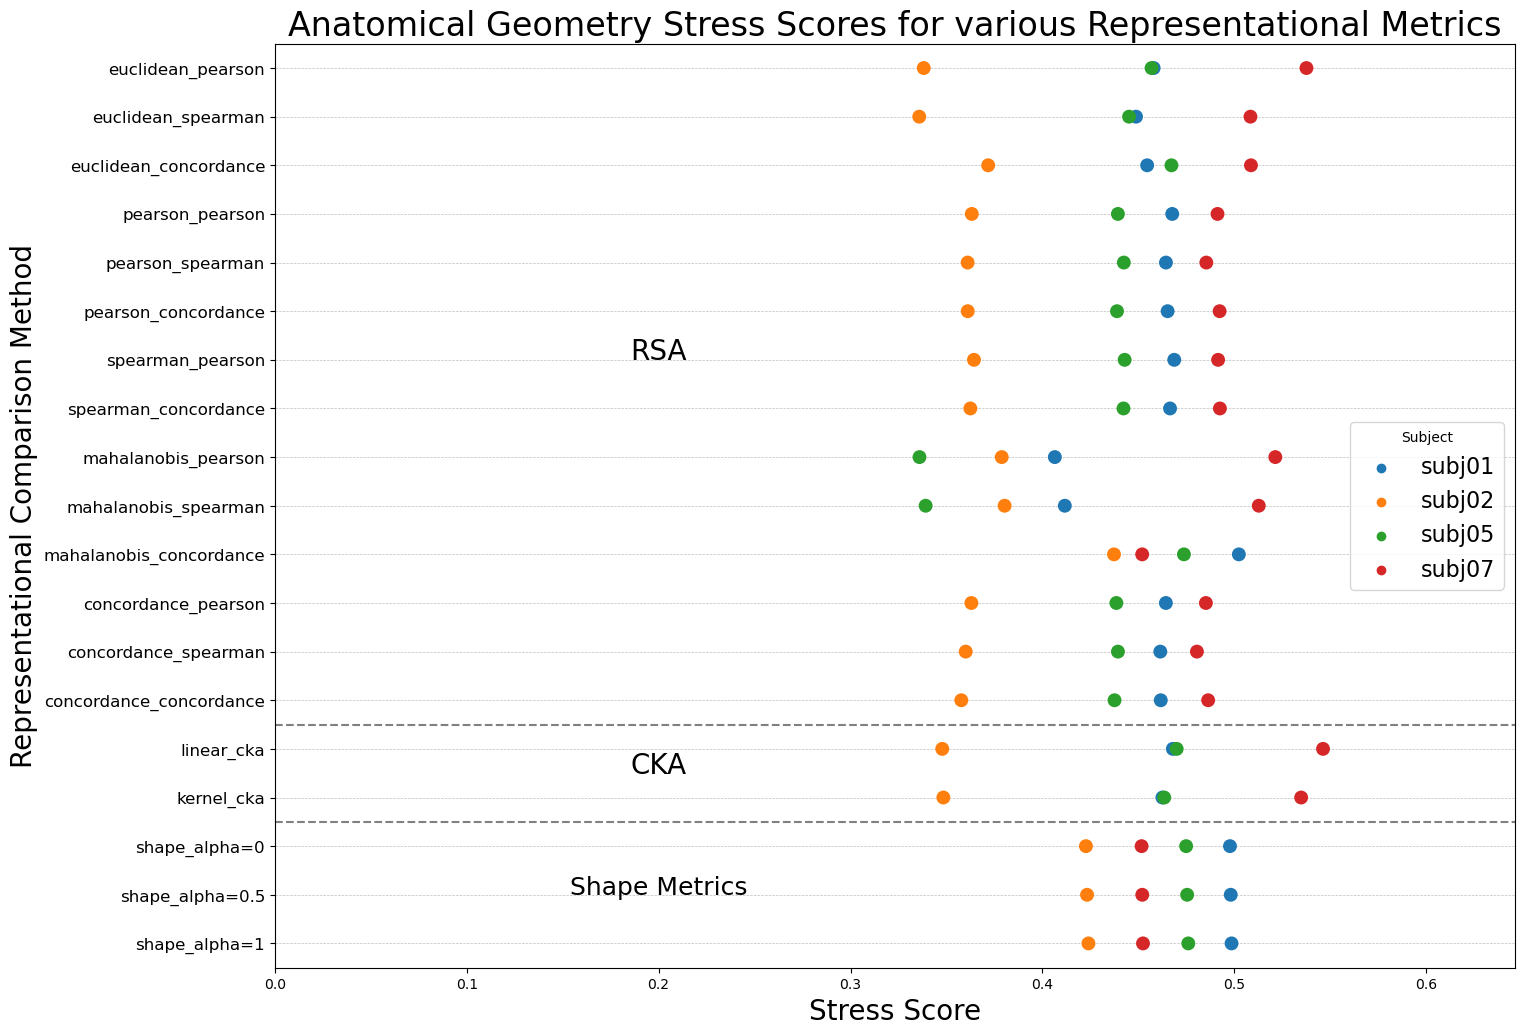

In [33]:
plt.figure(figsize=(16, 12))
sns.stripplot(y='test', x='stress_score', hue='subject', data=all_data, jitter=False, dodge=False, size = 10)
#plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Representational Comparison Method', fontsize=20)
plt.xlabel('Stress Score', fontsize=20)
plt.title('Anatomical Geometry Stress Scores for various Representational Metrics', fontsize=24)
# Draw vertical lines to separate meta-categories
plt.axhline(y=13.5, color='gray', linestyle='--')
plt.axhline(y=15.5, color='gray', linestyle='--')
max_value = all_data['stress_score'].max()
plt.xlim(0,max_value + 0.1)

ax = plt.gca()
for y_value in sorted(all_data['test'].unique()):
    ax.axhline(y=y_value, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)



xmin, ymax = plt.ylim()

# Add text annotations for meta-categories
plt.text(0.2,6, 'RSA', horizontalalignment='center', fontsize=20)
plt.text(0.2,14.5, 'CKA', horizontalalignment='center', fontsize=20)
plt.text(0.2,17, 'Shape Metrics', horizontalalignment='center', fontsize=18)

plt.legend(title='Subject', fontsize=16)
plt.show()

In [23]:
with open('shape_final_matrices.pkl', 'rb') as f:
    saved_shape_matrices = pickle.load(f)

In [27]:
saved_shape_matrices["subj05"]["shape_alpha=0.5"]["matrix"]

array([[0.        , 1.12026467, 1.13028138, 1.0954955 , 1.15487782,
        1.12993662, 1.15843464, 1.13431463, 1.17020694, 1.1492243 ,
        1.10256936],
       [1.12026467, 0.        , 0.86954496, 1.05186908, 1.12786096,
        1.02600462, 1.13694255, 1.05925395, 1.14321049, 1.13159725,
        1.10507791],
       [1.13028138, 0.86954496, 0.        , 1.05919492, 1.14506076,
        1.10910764, 1.12658068, 1.07399126, 1.04384187, 1.07274739,
        1.13160427],
       [1.0954955 , 1.05186908, 1.05919492, 0.        , 1.05556795,
        0.97198108, 1.13196131, 0.99100381, 1.11847746, 1.09456906,
        0.94567585],
       [1.15487782, 1.12786096, 1.14506076, 1.05556795, 0.        ,
        0.88223833, 1.18294029, 1.13031533, 1.18487535, 1.17855062,
        1.10276368],
       [1.12993662, 1.02600462, 1.10910764, 0.97198108, 0.88223833,
        0.        , 1.15717354, 1.02558921, 1.16484275, 1.14855752,
        1.07399442],
       [1.15843464, 1.13694255, 1.12658068, 1.13196131, 1.

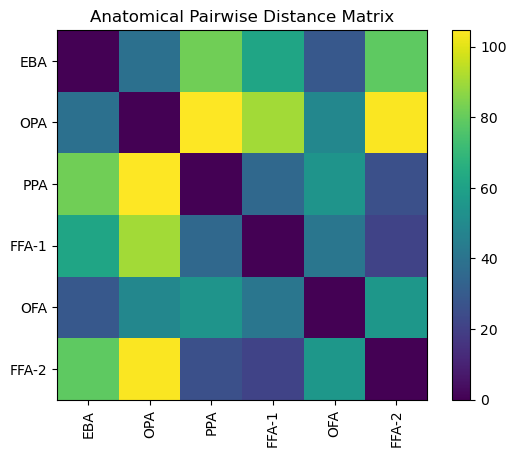

In [18]:
import matplotlib.pyplot as plt
import numpy as np
subject = "subj07"
plt.imshow(anatomy[subject])
plt.xticks(
    ticks=np.arange(len(rois[subject])), labels=rois[subject], rotation=90
)
plt.yticks(ticks=np.arange(len(rois[subject])), labels=rois[subject])
plt.title(f"Anatomical Pairwise Distance Matrix")
cbar = plt.colorbar()

## Load tests from csv file and compute variance across subjects

In [12]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("../neurometry/rep_metrics/results/stress_scores.csv")

# Calculate the variance of stress_score for each test
variance_by_test = df.groupby("test")["stress_score"].var()

# Convert the Series object to an array
variance_array = variance_by_test.values

# Print the array of variances
print(variance_array)

[0.00310888 0.00284966 0.00280321 0.00329573 0.00675738 0.0051743
 0.00594707 0.00672446 0.00080067 0.00629161 0.00548713 0.00320188
 0.00309687 0.00296308 0.0010321  0.00102875 0.00102263 0.00315874
 0.00306744]


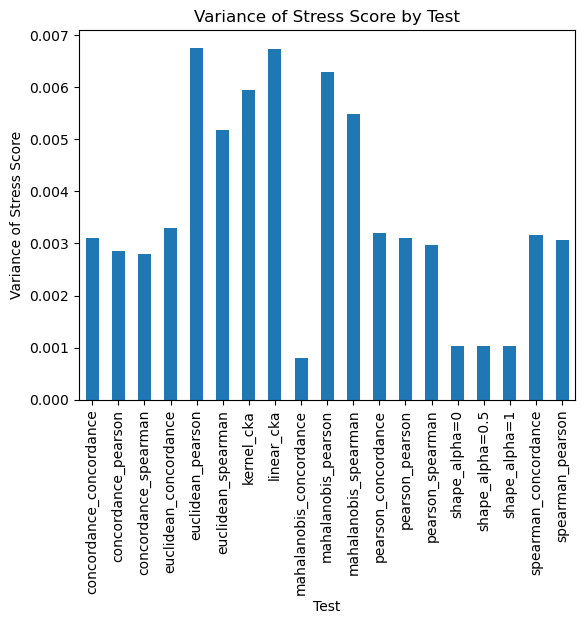

In [13]:
# Create a bar plot
variance_by_test.plot(kind="bar")

# Set the title and labels
plt.title("Variance of Stress Score by Test")
plt.xlabel("Test")
plt.ylabel("Variance of Stress Score")

# Show the plot
plt.show()

In [14]:
# Calculate the mean and standard deviation for each test
stats_by_test = df.groupby("test")["stress_score"].agg(["mean", "std"])

# Calculate the coefficient of variation for each test and add it as a new column
stats_by_test["cv"] = stats_by_test["std"] / stats_by_test["mean"]

# Print the result
print(stats_by_test["cv"])

test
concordance_concordance    0.127934
concordance_pearson        0.121946
concordance_spearman       0.121622
euclidean_concordance      0.127421
euclidean_pearson          0.183639
euclidean_spearman         0.165543
kernel_cka                 0.170503
linear_cka                 0.179054
mahalanobis_concordance    0.060677
mahalanobis_pearson        0.193167
mahalanobis_spearman       0.180253
pearson_concordance        0.128787
pearson_pearson            0.126377
pearson_spearman           0.124195
shape_alpha=0              0.069577
shape_alpha=0.5            0.069395
shape_alpha=1              0.069108
spearman_concordance       0.127469
spearman_pearson           0.125348
Name: cv, dtype: float64


In [16]:
from scipy import stats

# Calculate the mean and standard deviation of the CVs
cv_mean = stats_by_test["cv"].mean()
cv_std = stats_by_test["cv"].std()

# Calculate the z-score for each test
stats_by_test["cv_z_score"] = (stats_by_test["cv"] - cv_mean) / cv_std

# Calculate the percentile rank for the particular test
particular_test_z_score = stats_by_test.loc[
    stats_by_test["cv"] == stats_by_test["cv"].min(), "cv_z_score"
].item()
particular_test_percentile = stats.percentileofscore(
    stats_by_test["cv"], stats_by_test["cv"].min()
)

# Print the percentile rank for the particular test
print(particular_test_percentile)

5.2631578947368425


In [17]:
print(stats_by_test["cv_z_score"])

test
concordance_concordance   -0.052532
concordance_pearson       -0.197383
concordance_spearman      -0.205216
euclidean_concordance     -0.064950
euclidean_pearson          1.294951
euclidean_spearman         0.857203
kernel_cka                 0.977178
linear_cka                 1.184021
mahalanobis_concordance   -1.679447
mahalanobis_pearson        1.525413
mahalanobis_spearman       1.213042
pearson_concordance       -0.031917
pearson_pearson           -0.090211
pearson_spearman          -0.142991
shape_alpha=0             -1.464172
shape_alpha=0.5           -1.468583
shape_alpha=1             -1.475504
spearman_concordance      -0.063797
spearman_pearson          -0.115103
Name: cv_z_score, dtype: float64


In [47]:
import sys

sys.path.append("../")
sys.path.append("../neurometry/rep_metrics/")
import neurometry.rep_metrics.config as config
import neurometry.rep_metrics.main as main

rsa_final_matrices = main.rsa_pairwise_matrices()

Now loading the shared1000 image set and the OTC-only voxel set...


/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (floc-places) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (floc-faces) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (floc-bodies) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/cortex/svgoverlay.py:499: UserWarning: Requested layer in svg file (prf-visualrois) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%s

Subject 1 has 662 voxels in region VWFA-1
Subject 1 has 269 voxels in region OFA
Subject 1 has 333 voxels in region FBA-1
Subject 1 has 2525 voxels in region EBA
Subject 1 has 418 voxels in region FFA-1
Subject 1 has 211 voxels in region FFA-2
Subject 1 has 1173 voxels in region OPA
Subject 1 has 359 voxels in region OWFA
Subject 1 has 734 voxels in region PPA
Subject 1 has 313 voxels in region FBA-2
Subject 1 has 355 voxels in region VWFA-2
Computing anatomical pairwise distance for subject subj01...
computing Frechet mean of VWFA-1...


/home/facosta/miniconda3/envs/neurometry/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


done.
computing Frechet mean of OFA...
done.
computing Frechet mean of FBA-1...
done.
computing Frechet mean of EBA...
done.
computing Frechet mean of FFA-1...
done.
computing Frechet mean of FFA-2...
skipping...
computing Frechet mean of OPA...
done.
computing Frechet mean of OWFA...
done.
computing Frechet mean of PPA...
done.
computing Frechet mean of FBA-2...
skipping...
computing Frechet mean of VWFA-2...
done.
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances on left cortex: 100%|██████████| 36/36.0 [04:05<00:00,  6.83s/it]  


done!
-----finished anatomical computations for all subjects-----
PCAing neural data for shape metrics analysis...
done!
Bootstrapping RSA pearson_pearson for subject subj01...
Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 78.91it/s]


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 92.34it/s]


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 131.99it/s]


Parallelizing n(n-1)/2 = 36 distance calculations with 32 processes.


Computing distances: 100%|██████████| 36/36.0 [00:00<00:00, 206.66it/s]

Finished bootstrapping RSA for subject subj01.
-----Finished RSA computations with bootstrapping for all subjects-----


In [50]:
rsa_final_matrices["subj01"]

defaultdict(<function neurometry.rep_metrics.main.rsa_pairwise_matrices.<locals>.<lambda>.<locals>.<lambda>()>,
            {'pearson_pearson': defaultdict(list,
                         {'stress': [0.6076160117922229,
                           0.607446330081254,
                           0.6075119695657668,
                           0.6076436092810251],
                          'mean_stress': 0.6075544801800672,
                          'ci_lower': 0.6074512530425925,
                          'ci_upper': 0.6076415394693649})})